In [1]:
"""
This script performs musical instrument classification using audio data.
It imports necessary libraries, preprocesses the data, builds a convolutional neural network model,
and evaluates the model's performance using confusion matrix.
"""

import os
import librosa
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from python_speech_features import mfcc
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from keras.models import Sequential

/tmp/ipykernel_369866/4236622008.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
2024-02-05 08:51:19.765699: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-05 08:51:20.593067: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [6]:
"""
Downloads the TinySOL dataset from Zenodo.
"""

! wget https://zenodo.org/records/3685367/files/TinySOL.tar.gz

--2024-02-03 23:59:53--  https://zenodo.org/records/3685367/files/TinySOL.tar.gz
Resolving zenodo.org (zenodo.org)... 2001:1458:d00:3a::100:33a, 2001:1458:d00:3b::100:200, 2001:1458:d00:9::100:195, ...
Connecting to zenodo.org (zenodo.org)|2001:1458:d00:3a::100:33a|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1026917185 (979M) [application/octet-stream]
Saving to: ‘TinySOL.tar.gz’

TinySOL.tar.gz      100%[===================>] 979.34M  5.60MB/s    in 3m 39s  

2024-02-04 00:03:32 (4.48 MB/s) - ‘TinySOL.tar.gz’ saved [1026917185/1026917185]



In [7]:
"""
Downloads the TinySOL_metadata.csv file from the given URL using wget.
"""

! wget https://zenodo.org/records/3685367/files/TinySOL_metadata.csv

--2024-02-04 00:03:48--  https://zenodo.org/records/3685367/files/TinySOL_metadata.csv
Resolving zenodo.org (zenodo.org)... 2001:1458:d00:3b::100:200, 2001:1458:d00:3a::100:33a, 2001:1458:d00:9::100:195, ...
Connecting to zenodo.org (zenodo.org)|2001:1458:d00:3b::100:200|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 317576 (310K) [text/plain]
Saving to: ‘TinySOL_metadata.csv’

TinySOL_metadata.cs 100%[===================>] 310.13K   408KB/s    in 0.8s    

2024-02-04 00:03:51 (408 KB/s) - ‘TinySOL_metadata.csv’ saved [317576/317576]



In [8]:
"""
Extracts the contents of the TinySOL.tar.gz file.
"""

! tar -zxvf TinySOL.tar.gz

./
./.DS_Store
./Winds/
./Winds/Flute/
./Winds/Flute/.DS_Store
./Winds/Flute/ordinario/
./Winds/Flute/ordinario/Fl-ord-F#4-mf-N-N.wav
./Winds/Flute/ordinario/Fl-ord-C5-mf-N-T17d.wav
./Winds/Flute/ordinario/Fl-ord-D#6-pp-N-N.wav
./Winds/Flute/ordinario/Fl-ord-F6-pp-N-N.wav
./Winds/Flute/ordinario/Fl-ord-B4-pp-N-N.wav
./Winds/Flute/ordinario/Fl-ord-D#5-pp-N-T10u.wav
./Winds/Flute/ordinario/Fl-ord-A4-mf-N-N.wav
./Winds/Flute/ordinario/Fl-ord-F6-mf-N-N.wav
./Winds/Flute/ordinario/Fl-ord-D6-pp-N-N.wav
./Winds/Flute/ordinario/Fl-ord-F#5-ff-N-T11d.wav
./Winds/Flute/ordinario/Fl-ord-F#6-mf-N-T10d.wav
./Winds/Flute/ordinario/Fl-ord-F#4-pp-N-N.wav
./Winds/Flute/ordinario/Fl-ord-A6-ff-N-T13d.wav
./Winds/Flute/ordinario/Fl-ord-D6-mf-N-T11d.wav
./Winds/Flute/ordinario/Fl-ord-C6-mf-N-T25d.wav
./Winds/Flute/ordinario/Fl-ord-G#4-pp-N-N.wav
./Winds/Flute/ordinario/Fl-ord-A#5-ff-N-T21d.wav
./Winds/Flute/ordinario/Fl-ord-F5-pp-N-N.wav
./Winds/Flute/ordinario/Fl-ord-A#6-ff-N-T15d.wav
./Winds/Flute/ordinar

In [2]:
"""
Reads a CSV file containing metadata for musical instruments and returns a DataFrame.

Parameters:
- file_path (str): The path to the CSV file.

Returns:
- df (pandas.DataFrame): The DataFrame containing the metadata.

"""
df = pd.read_csv('TinySOL_metadata.csv')    
df.head()

,Path,Fold,Family,Instrument (abbr.),Instrument (in full),Technique (abbr.),Technique (in full),Pitch,Pitch ID,Dynamics,Dynamics ID,Instance ID,String ID (if applicable),Needed digital retuning
0,Brass/Bass_Tuba/ordinario/BTb-ord-F#1-pp-N-N.wav,2,Brass,BTb,Bass Tuba,ord,ordinario,F#1,30,pp,0,0,NaN,False
1,Brass/Bass_Tuba/ordinario/BTb-ord-G1-pp-N-R100...,4,Brass,BTb,Bass Tuba,ord,ordinario,G1,31,pp,0,0,NaN,True
2,Brass/Bass_Tuba/ordinario/BTb-ord-G#1-pp-N-T16...,3,Brass,BTb,Bass Tuba,ord,ordinario,G#1,32,pp,0,0,NaN,True
3,Brass/Bass_Tuba/ordinario/BTb-ord-A1-pp-N-T23d...,2,Brass,BTb,Bass Tuba,ord,ordinario,A1,33,pp,0,0,NaN,True
4,Brass/Bass_Tuba/ordinario/BTb-ord-A#1-pp-N-N.wav,0,Brass,BTb,Bass Tuba,ord,ordinario,A#1,34,pp,0,0,NaN,False


In [3]:
'''Load the audio data using librosa.load() and store it in a list called audio_data and then convert the list to a numpy array.'''
path = 'audio_train/'
audio_data = list() 
for i in tqdm(range(df.shape[0])):
    audio_data.append(librosa.load(path+df['Path'].iloc[i]))

audio_data = np.array(audio_data)

100%|██████████| 2913/2913 [00:11<00:00, 259.20it/s]
/tmp/ipykernel_369866/849988725.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  audio_data = np.array(audio_data)


In [4]:
'''Process the audio data and add it to the DataFrame.'''
df['audio_waves'] = audio_data[:,0]
df['samplerate'] = audio_data[:,1]

df.head()

,Path,Fold,Family,Instrument (abbr.),Instrument (in full),Technique (abbr.),Technique (in full),Pitch,Pitch ID,Dynamics,Dynamics ID,Instance ID,String ID (if applicable),Needed digital retuning,audio_waves,samplerate
0,Brass/Bass_Tuba/ordinario/BTb-ord-F#1-pp-N-N.wav,2,Brass,BTb,Bass Tuba,ord,ordinario,F#1,30,pp,0,0,NaN,False,"[9.036441e-06, 1.0625277e-05, -1.9754421e-05, ...",22050
1,Brass/Bass_Tuba/ordinario/BTb-ord-G1-pp-N-R100...,4,Brass,BTb,Bass Tuba,ord,ordinario,G1,31,pp,0,0,NaN,True,"[3.616442e-07, -1.4153338e-06, 2.2828739e-05, ...",22050
2,Brass/Bass_Tuba/ordinario/BTb-ord-G#1-pp-N-T16...,3,Brass,BTb,Bass Tuba,ord,ordinario,G#1,32,pp,0,0,NaN,True,"[1.1558761e-05, 1.9725412e-06, -3.1382893e-05,...",22050
3,Brass/Bass_Tuba/ordinario/BTb-ord-A1-pp-N-T23d...,2,Brass,BTb,Bass Tuba,ord,ordinario,A1,33,pp,0,0,NaN,True,"[-3.4891127e-06, 4.337897e-06, 9.174459e-06, 1...",22050
4,Brass/Bass_Tuba/ordinario/BTb-ord-A#1-pp-N-N.wav,0,Brass,BTb,Bass Tuba,ord,ordinario,A#1,34,pp,0,0,NaN,False,"[3.059562e-06, -3.27437e-06, -1.1771277e-05, 1...",22050


In [5]:
'''Calculates the bit lengths and seconds length for each audio wave in the DataFrame.'''
bit_lengths = list()
for i in range(df.shape[0]):
    bit_lengths.append(len(df['audio_waves'].iloc[i]))
bit_lengths = np.array(bit_lengths)

df['bit_lengths'] = bit_lengths
df['seconds_length'] = df['bit_lengths']/df['samplerate']
df.head()

,Path,Fold,Family,Instrument (abbr.),Instrument (in full),Technique (abbr.),Technique (in full),Pitch,Pitch ID,Dynamics,Dynamics ID,Instance ID,String ID (if applicable),Needed digital retuning,audio_waves,samplerate,bit_lengths,seconds_length
0,Brass/Bass_Tuba/ordinario/BTb-ord-F#1-pp-N-N.wav,2,Brass,BTb,Bass Tuba,ord,ordinario,F#1,30,pp,0,0,NaN,False,"[9.036441e-06, 1.0625277e-05, -1.9754421e-05, ...",22050,67253,3.050023
1,Brass/Bass_Tuba/ordinario/BTb-ord-G1-pp-N-R100...,4,Brass,BTb,Bass Tuba,ord,ordinario,G1,31,pp,0,0,NaN,True,"[3.616442e-07, -1.4153338e-06, 2.2828739e-05, ...",22050,63479,2.878866
2,Brass/Bass_Tuba/ordinario/BTb-ord-G#1-pp-N-T16...,3,Brass,BTb,Bass Tuba,ord,ordinario,G#1,32,pp,0,0,NaN,True,"[1.1558761e-05, 1.9725412e-06, -3.1382893e-05,...",22050,73620,3.338776
3,Brass/Bass_Tuba/ordinario/BTb-ord-A1-pp-N-T23d...,2,Brass,BTb,Bass Tuba,ord,ordinario,A1,33,pp,0,0,NaN,True,"[-3.4891127e-06, 4.337897e-06, 9.174459e-06, 1...",22050,67961,3.082132
4,Brass/Bass_Tuba/ordinario/BTb-ord-A#1-pp-N-N.wav,0,Brass,BTb,Bass Tuba,ord,ordinario,A#1,34,pp,0,0,NaN,False,"[3.059562e-06, -3.27437e-06, -1.1771277e-05, 1...",22050,76472,3.468118


In [6]:
# Discard audio waves that are less than 2 seconds long
df = df[df['seconds_length'] >= 2.0]


In [7]:
# Prints the minimum values of 'bit_lengths' and 'seconds_length' columns from the DataFrame
min_bits = np.min(df['bit_lengths'])
print(min_bits)
min_seconds = np.min(df['seconds_length'])
print(min_seconds)

49657
2.252018140589569


In [8]:
"""
Generate audio waves and labels for musical instrument classification.

Parameters:
- num_samples (int): The number of samples to generate.
- df (pandas.DataFrame): The dataframe containing the audio data and labels.
- min_bits (int): The minimum number of bits to extract from each audio wave.

Returns:
- generated_audio_waves (numpy.ndarray): An array of generated audio waves.
- generated_audio_labels (numpy.ndarray): An array of corresponding instrument labels.
"""

num_samples = 6000
generated_audio_waves = list()
generated_audio_labels = list()
for i in tqdm(range(num_samples)):
    try:
        chosen_file = np.random.choice(df['Path'].values)
        chosen_initial = np.random.choice(np.arange(0,df[df['Path']==chosen_file]['bit_lengths'].values-min_bits))
        generated_audio_waves.append(df[df['Path']==chosen_file]['audio_waves'].values[0][chosen_initial:chosen_initial+min_bits])
        
        generated_audio_labels.append(df[df['Path']==chosen_file]['Instrument (in full)'].values)
    except ValueError:
        continue
generated_audio_waves = np.array(generated_audio_waves)
generated_audio_labels = np.array(generated_audio_labels)


100%|██████████| 6000/6000 [00:06<00:00, 926.64it/s]


In [9]:
# Extracts Mel-frequency cepstral coefficients (MFCC) features from a list of generated audio waves.
mfcc_features = list()
for i in tqdm(range(len(generated_audio_waves))):
    mfcc_features.append(mfcc(generated_audio_waves[i]))

mfcc_features = np.array(mfcc_features)

100%|██████████| 5995/5995 [00:34<00:00, 175.52it/s]


In [10]:
print(generated_audio_waves.shape)
print(mfcc_features.shape)

(5995, 49657)
(5995, 309, 13)


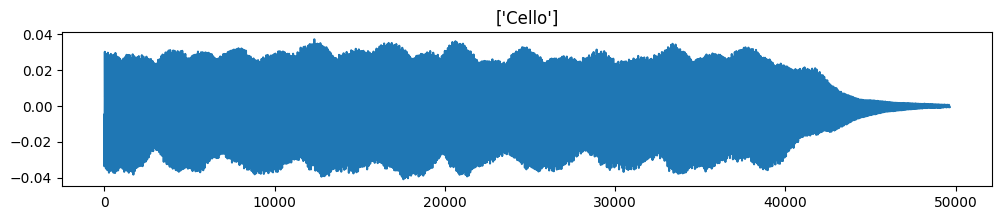

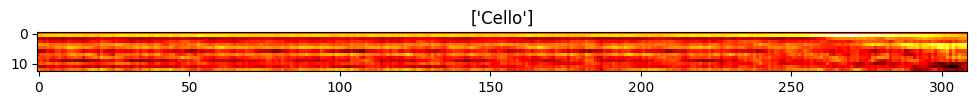

In [11]:

"""
Plot the generated audio waves and MFCC features for a specific index in the dataset.

Parameters:
- generated_audio_waves: A list of generated audio waves.
- generated_audio_labels: A list of labels corresponding to the generated audio waves.
- mfcc_features: A list of MFCC features.

Returns:
- None
"""

plt.figure(figsize=(12,2))
plt.plot(generated_audio_waves[30])
plt.title(generated_audio_labels[30])
plt.show()
plt.figure(figsize=(12, 2))
plt.imshow(mfcc_features[30].T, cmap='hot')
plt.title(generated_audio_labels[30])
plt.show()

In [12]:
#Encodes the given audio labels using LabelEncoder.
label_encoder = LabelEncoder()
label_encoded = label_encoder.fit_transform(generated_audio_labels)
print(label_encoded)

[ 9 13  6 ...  2 12 12]


/home/hitaish/Documents/musical_instrument_classification/music/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [13]:
"""
Converts the label_encoded array into a 2-dimensional array by adding a new axis.
Returns the modified label_encoded array.
"""
label_encoded = label_encoded[:, np.newaxis]
label_encoded



array([[ 9],
       [13],
       [ 6],
       ...,
       [ 2],
       [12],
       [12]])

In [14]:
# Encode the labels using one-hot encoding.
one_hot_encoder = OneHotEncoder(sparse_output=False)
one_hot_encoded = one_hot_encoder.fit_transform(label_encoded)
one_hot_encoded

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

In [15]:
"""
Preprocesses the data for musical instrument classification.

Parameters:
    X (numpy.ndarray): The input features.
    y (numpy.ndarray): The target labels.
    
Returns:
    X_train (numpy.ndarray): The preprocessed training features.
    X_test (numpy.ndarray): The preprocessed testing features.
    y_train (numpy.ndarray): The training labels.
    y_test (numpy.ndarray): The testing labels.
"""
X = mfcc_features
y = one_hot_encoded
X = (X-X.min())/(X.max()-X.min())
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [16]:
y_train.shape

(4796, 14)

In [17]:
input_shape = (X_train.shape[1], X_train.shape[2], 1)

In [18]:

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
print(X_train.shape)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
print(X_test.shape)

(4796, 309, 13, 1)
(1199, 309, 13, 1)


In [19]:
y_train.shape  # (number_of_samples, number_of_classes)

(4796, 14)

In [20]:
# Create a convolutional neural network model for musical instrument classification.
model = Sequential()
model.add(Conv2D(16, (3, 3), activation='relu', strides=(1, 1), padding='same', input_shape=input_shape))
model.add(Conv2D(32, (3, 3), activation='relu', strides=(1, 1), padding='same'))
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(14, activation='softmax'))  
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


2024-02-05 08:53:03.989008: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2024-02-05 08:53:03.989044: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: hitaish-OMEN-Laptop-15-en1xxx
2024-02-05 08:53:03.989052: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: hitaish-OMEN-Laptop-15-en1xxx
2024-02-05 08:53:03.989305: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 535.154.5
2024-02-05 08:53:03.989334: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 535.154.5
2024-02-05 08:53:03.989340: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 535.154.5


In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 309, 13, 16)       160       
                                                                 
 conv2d_1 (Conv2D)           (None, 309, 13, 32)       4640      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 154, 6, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 154, 6, 32)        0         
                                                                 
 flatten (Flatten)           (None, 29568)             0         
                                                                 
 dense (Dense)               (None, 128)               3784832   
                                                        

In [22]:
# Train the model.
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test))

Epoch 1/30


2024-02-05 08:53:07.157567: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 77062128 exceeds 10% of free system memory.


150/150 [==============================] - 12s 74ms/step - loss: 2.3230 - accuracy: 0.2415 - val_loss: 1.8560 - val_accuracy: 0.4120
Epoch 2/30
150/150 [==============================] - 11s 72ms/step - loss: 1.7835 - accuracy: 0.4060 - val_loss: 1.2897 - val_accuracy: 0.5972
Epoch 3/30
150/150 [==============================] - 11s 72ms/step - loss: 1.4927 - accuracy: 0.4937 - val_loss: 1.1115 - val_accuracy: 0.6589
Epoch 4/30
150/150 [==============================] - 11s 72ms/step - loss: 1.3370 - accuracy: 0.5457 - val_loss: 0.9864 - val_accuracy: 0.7148
Epoch 5/30
150/150 [==============================] - 11s 72ms/step - loss: 1.2162 - accuracy: 0.5903 - val_loss: 0.8817 - val_accuracy: 0.7148
Epoch 6/30
150/150 [==============================] - 11s 72ms/step - loss: 1.1219 - accuracy: 0.6155 - val_loss: 0.7702 - val_accuracy: 0.7523
Epoch 7/30
150/150 [==============================] - 11s 72ms/step - loss: 1.0742 - accuracy: 0.6303 - val_loss: 0.7297 - val_accuracy: 0.7706
Epo

loss: 0.6426742076873779
val_loss: 0.4600883424282074


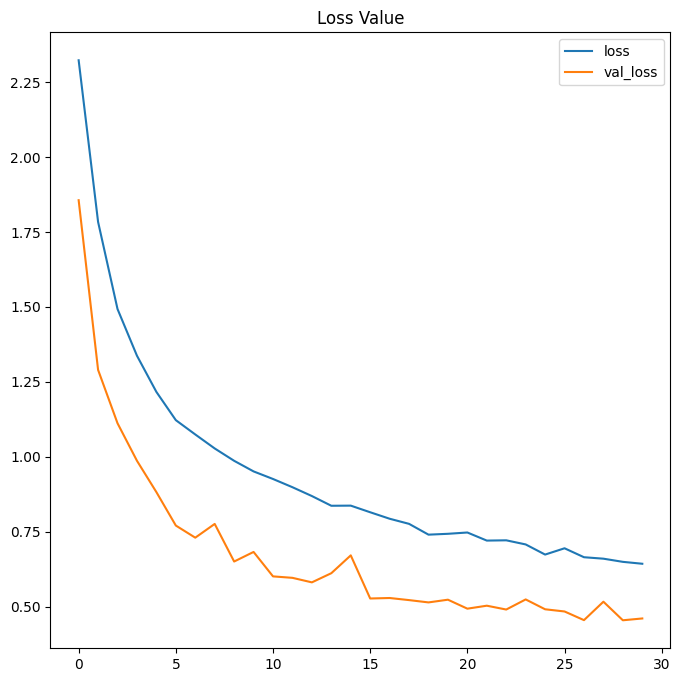

accuracy: 0.7743953466415405
val_acc: 0.8615512847900391


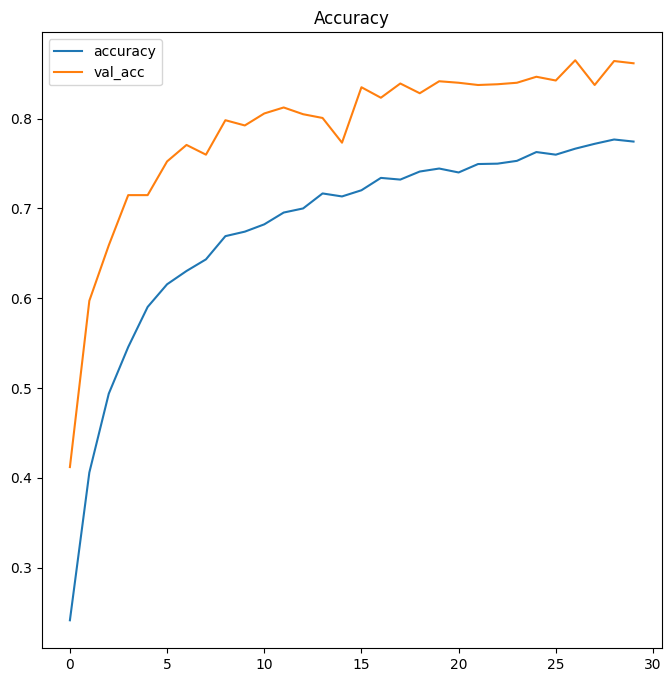

In [23]:
"""
Plots the loss value and accuracy of a model training history.

Parameters:
- history: A dictionary containing the training history of the model.

Returns:
None
"""
plt.figure(figsize=(8,8))
plt.title('Loss Value')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
print('loss:', history.history['loss'][-1])
print('val_loss:', history.history['val_loss'][-1])
plt.show()
plt.figure(figsize=(8,8))
plt.title('Accuracy')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['accuracy', 'val_acc'])
print('accuracy:', history.history['accuracy'][-1])
print('val_acc:', history.history['val_accuracy'][-1])
plt.show()

In [55]:
import pickle
# Specify the file path where you want to save the pickle file
file_path = "history_gt.pickle"

# Save the model history to a pickle file
with open(file_path, "wb") as file:
    pickle.dump(history.history, file)


In [24]:
# Save the model to a file.
model.save('instrument_classifier1.h5')

In [47]:
from sklearn.preprocessing import LabelEncoder

# Assuming 'label_encoder' is the instance of LabelEncoder
label_encoder = LabelEncoder()

# Assuming 'generated_audio_labels' is the array of labels
label_encoded = label_encoder.fit_transform(generated_audio_labels)

# Retrieve the classes
classes = label_encoder.classes_
print(classes)


['Accordion' 'Alto Saxophone' 'Bass Tuba' 'Bassoon' 'Cello'
 'Clarinet in Bb' 'Contrabass' 'Flute' 'French Horn' 'Oboe' 'Trombone'
 'Trumpet in C' 'Viola' 'Violin']


/home/hitaish/Documents/musical_instrument_classification/music/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [25]:
"""
This code snippet loads audio files, computes Mel spectrograms, and predicts instrument labels using a model.
The processed data is stored in lists and then converted into a DataFrame, which is saved as a CSV file.
"""

# Create empty lists to store the information
paths = []
instruments = []
mel_spectrograms = []
audio_data = []
pseudo_labels = []

# Create a label encoder to map instrument names to integers
label_encoder = LabelEncoder()

# Iterate through the dataframe
for i in tqdm(range(len(df))):
    path = 'audio_train/' + df['Path'].iloc[i]
    
    # Load audio
    audio, sr = librosa.load(path, sr=None)
    
    # Resample audio if necessary
    if sr != 22050:
        audio = librosa.resample(audio, orig_sr=sr, target_sr=22050)
    
    # Convert to mono if it's not already
    if audio.ndim > 1:
        audio = librosa.to_mono(audio)

    # Compute Mel spectrogram
    mel = librosa.feature.melspectrogram(y=audio, sr=22050, n_mels=309, n_fft=2048)
    mel = librosa.power_to_db(mel)

    # Normalize Mel spectrogram
    mel = (mel - mel.min()) / (mel.max() - mel.min())

    # Add batch dimension
    mel = mel[:, :13, None]
    mel = mel.reshape((1, 309, 13, 1))

    # Predict using the model (replace this with your model prediction logic)
    pseudo_label = np.argmax(model.predict(mel)[0]) # Replace with your actual prediction logic
    
    # Append data to lists
    paths.append(df['Path'].iloc[i])
    instruments.append(df['Instrument (in full)'].iloc[i])
    mel_spectrograms.append(mel)
    audio_data.append(audio)
    pseudo_labels.append(pseudo_label)

# Create a DataFrame
data = {
    'Path': paths,
    'Instrument (in full)': instruments,
    'mel_spectrum': mel_spectrograms,
    'audio': audio_data,
    'pseudo': pseudo_labels
}

df_final = pd.DataFrame(data)

# Save DataFrame to CSV
df_final.to_csv('output_file.csv', index=False)


  0%|          | 0/2875 [00:00<?, ?it/s]

1/1 [==============================] - 0s 87ms/step


  0%|          | 1/2875 [00:00<07:30,  6.38it/s]

1/1 [==============================] - 0s 17ms/step


  0%|          | 3/2875 [00:00<04:20, 11.03it/s]

1/1 [==============================] - 0s 17ms/step


  0%|          | 5/2875 [00:00<03:39, 13.10it/s]

1/1 [==============================] - 0s 21ms/step


  0%|          | 7/2875 [00:00<03:55, 12.20it/s]

1/1 [==============================] - 0s 21ms/step


  0%|          | 9/2875 [00:00<04:06, 11.64it/s]

1/1 [==============================] - 0s 18ms/step


  0%|          | 11/2875 [00:00<03:50, 12.45it/s]

1/1 [==============================] - 0s 35ms/step


  0%|          | 13/2875 [00:01<03:53, 12.28it/s]

1/1 [==============================] - 0s 32ms/step


  1%|          | 15/2875 [00:01<03:50, 12.42it/s]

1/1 [==============================] - 0s 28ms/step


  1%|          | 17/2875 [00:01<03:53, 12.22it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 19/2875 [00:01<03:52, 12.26it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 21/2875 [00:01<03:51, 12.32it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 23/2875 [00:01<03:49, 12.41it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 25/2875 [00:02<03:46, 12.56it/s]

1/1 [==============================] - 0s 18ms/step


  1%|          | 27/2875 [00:02<04:13, 11.22it/s]

1/1 [==============================] - 0s 18ms/step


  1%|          | 29/2875 [00:02<03:47, 12.48it/s]

1/1 [==============================] - 0s 28ms/step


  1%|          | 31/2875 [00:02<04:03, 11.68it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 33/2875 [00:02<04:13, 11.21it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 35/2875 [00:02<04:18, 10.98it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 37/2875 [00:03<04:32, 10.40it/s]

1/1 [==============================] - 0s 21ms/step


  1%|▏         | 39/2875 [00:03<04:06, 11.50it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 41/2875 [00:03<03:52, 12.19it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 43/2875 [00:03<03:47, 12.43it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 45/2875 [00:03<03:59, 11.82it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 47/2875 [00:04<04:27, 10.58it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 49/2875 [00:04<03:59, 11.79it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 51/2875 [00:04<03:43, 12.66it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 53/2875 [00:04<03:35, 13.10it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 55/2875 [00:04<03:30, 13.40it/s]

1/1 [==============================] - 0s 24ms/step


  2%|▏         | 57/2875 [00:04<03:40, 12.80it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 59/2875 [00:04<03:38, 12.86it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 61/2875 [00:05<03:48, 12.30it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 63/2875 [00:05<04:03, 11.55it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 65/2875 [00:05<03:47, 12.38it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 67/2875 [00:05<03:30, 13.33it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 69/2875 [00:05<03:43, 12.55it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 71/2875 [00:05<03:40, 12.70it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 73/2875 [00:06<04:21, 10.70it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 75/2875 [00:06<04:16, 10.93it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 77/2875 [00:06<04:13, 11.03it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 79/2875 [00:06<03:54, 11.91it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 81/2875 [00:06<03:55, 11.87it/s]

1/1 [==============================] - 0s 26ms/step


  3%|▎         | 83/2875 [00:06<04:01, 11.57it/s]

1/1 [==============================] - 0s 24ms/step


  3%|▎         | 85/2875 [00:07<04:04, 11.39it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 87/2875 [00:07<03:50, 12.08it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 89/2875 [00:07<03:53, 11.95it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 91/2875 [00:07<04:02, 11.50it/s]

1/1 [==============================] - 0s 16ms/step


  3%|▎         | 93/2875 [00:07<03:52, 11.98it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 95/2875 [00:07<03:42, 12.52it/s]

1/1 [==============================] - 0s 40ms/step


  3%|▎         | 97/2875 [00:08<04:12, 11.02it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 99/2875 [00:08<03:56, 11.74it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▎         | 101/2875 [00:08<03:47, 12.22it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▎         | 103/2875 [00:08<03:43, 12.41it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▎         | 105/2875 [00:08<03:35, 12.87it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▎         | 107/2875 [00:08<03:32, 13.00it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 109/2875 [00:09<03:29, 13.17it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 111/2875 [00:09<03:43, 12.37it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 113/2875 [00:09<03:33, 12.95it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▍         | 115/2875 [00:09<03:34, 12.89it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 117/2875 [00:09<03:37, 12.65it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 119/2875 [00:09<03:27, 13.30it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 121/2875 [00:10<03:35, 12.76it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 123/2875 [00:10<04:06, 11.15it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 125/2875 [00:10<03:53, 11.79it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 127/2875 [00:10<03:50, 11.92it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 129/2875 [00:10<03:44, 12.22it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 131/2875 [00:10<03:38, 12.57it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▍         | 133/2875 [00:11<03:33, 12.84it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▍         | 135/2875 [00:11<03:26, 13.29it/s]

1/1 [==============================] - 0s 31ms/step


  5%|▍         | 137/2875 [00:11<03:49, 11.92it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▍         | 139/2875 [00:11<03:38, 12.51it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▍         | 141/2875 [00:11<03:33, 12.79it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▍         | 143/2875 [00:11<03:22, 13.52it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 145/2875 [00:11<03:17, 13.85it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▌         | 147/2875 [00:12<03:43, 12.21it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▌         | 149/2875 [00:12<03:33, 12.76it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 151/2875 [00:12<03:32, 12.82it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 153/2875 [00:12<03:30, 12.91it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 155/2875 [00:12<03:39, 12.42it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▌         | 157/2875 [00:12<03:37, 12.51it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 159/2875 [00:13<03:46, 12.00it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 161/2875 [00:13<03:49, 11.85it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 163/2875 [00:13<03:52, 11.69it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 165/2875 [00:13<03:51, 11.72it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 167/2875 [00:13<04:04, 11.07it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 169/2875 [00:13<03:46, 11.93it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▌         | 171/2875 [00:14<04:08, 10.89it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 173/2875 [00:14<03:58, 11.34it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 175/2875 [00:14<04:02, 11.12it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 177/2875 [00:14<03:57, 11.35it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 179/2875 [00:14<03:57, 11.37it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▋         | 181/2875 [00:15<03:52, 11.61it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▋         | 183/2875 [00:15<03:58, 11.28it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▋         | 185/2875 [00:15<03:59, 11.25it/s]

1/1 [==============================] - 0s 16ms/step


  7%|▋         | 187/2875 [00:15<04:20, 10.32it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 189/2875 [00:15<04:20, 10.29it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 191/2875 [00:16<04:32,  9.85it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 193/2875 [00:16<04:25, 10.08it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 195/2875 [00:16<04:30,  9.90it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 197/2875 [00:16<04:13, 10.57it/s]

1/1 [==============================] - 0s 17ms/step


  7%|▋         | 199/2875 [00:16<03:56, 11.29it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 201/2875 [00:16<03:51, 11.56it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 203/2875 [00:17<03:47, 11.76it/s]

1/1 [==============================] - 0s 17ms/step


  7%|▋         | 205/2875 [00:17<03:48, 11.68it/s]

1/1 [==============================] - 0s 17ms/step


  7%|▋         | 207/2875 [00:17<03:52, 11.49it/s]

1/1 [==============================] - 0s 17ms/step


  7%|▋         | 209/2875 [00:17<03:54, 11.36it/s]

1/1 [==============================] - 0s 17ms/step


  7%|▋         | 211/2875 [00:17<04:04, 10.91it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 213/2875 [00:17<04:03, 10.95it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 215/2875 [00:18<04:06, 10.77it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 217/2875 [00:18<03:59, 11.10it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 219/2875 [00:18<04:17, 10.33it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 221/2875 [00:18<04:07, 10.71it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 223/2875 [00:18<04:02, 10.96it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 225/2875 [00:19<03:58, 11.13it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 227/2875 [00:19<03:55, 11.24it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 229/2875 [00:19<03:54, 11.29it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 231/2875 [00:19<03:55, 11.21it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 233/2875 [00:19<03:58, 11.07it/s]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 235/2875 [00:19<04:01, 10.95it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 237/2875 [00:20<03:59, 11.00it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 239/2875 [00:20<03:44, 11.74it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 241/2875 [00:20<03:47, 11.58it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 243/2875 [00:20<03:50, 11.42it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▊         | 245/2875 [00:20<03:41, 11.85it/s]

1/1 [==============================] - 0s 14ms/step


  9%|▊         | 247/2875 [00:20<03:39, 11.96it/s]

1/1 [==============================] - 0s 23ms/step


  9%|▊         | 249/2875 [00:21<03:47, 11.55it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▊         | 251/2875 [00:21<03:47, 11.53it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 253/2875 [00:21<03:39, 11.96it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▉         | 255/2875 [00:21<03:35, 12.17it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 257/2875 [00:21<03:28, 12.56it/s]

1/1 [==============================] - 0s 23ms/step


  9%|▉         | 259/2875 [00:21<03:35, 12.12it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 261/2875 [00:22<03:21, 12.99it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 263/2875 [00:22<03:17, 13.25it/s]

1/1 [==============================] - 0s 37ms/step


  9%|▉         | 265/2875 [00:22<03:27, 12.56it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 267/2875 [00:22<03:27, 12.59it/s]

1/1 [==============================] - 0s 31ms/step


  9%|▉         | 269/2875 [00:22<03:33, 12.20it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 271/2875 [00:22<03:47, 11.44it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 273/2875 [00:23<03:46, 11.47it/s]

1/1 [==============================] - 0s 24ms/step


 10%|▉         | 275/2875 [00:23<03:57, 10.97it/s]

1/1 [==============================] - 0s 24ms/step


 10%|▉         | 277/2875 [00:23<03:38, 11.90it/s]

1/1 [==============================] - 0s 23ms/step


 10%|▉         | 279/2875 [00:23<03:34, 12.09it/s]

1/1 [==============================] - 0s 17ms/step


 10%|▉         | 281/2875 [00:23<03:39, 11.80it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 283/2875 [00:23<03:42, 11.64it/s]

1/1 [==============================] - 0s 18ms/step


 10%|▉         | 285/2875 [00:24<03:30, 12.28it/s]

1/1 [==============================] - 0s 23ms/step


 10%|▉         | 287/2875 [00:24<03:33, 12.12it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 289/2875 [00:24<04:02, 10.65it/s]

1/1 [==============================] - 0s 26ms/step


 10%|█         | 291/2875 [00:24<03:56, 10.91it/s]

1/1 [==============================] - 0s 22ms/step


 10%|█         | 293/2875 [00:24<04:05, 10.53it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 295/2875 [00:25<03:47, 11.35it/s]

1/1 [==============================] - 0s 28ms/step


 10%|█         | 297/2875 [00:25<03:46, 11.38it/s]

1/1 [==============================] - 0s 32ms/step


 10%|█         | 299/2875 [00:25<03:58, 10.82it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 301/2875 [00:25<03:33, 12.05it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 303/2875 [00:25<03:31, 12.13it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█         | 305/2875 [00:25<03:30, 12.20it/s]

1/1 [==============================] - 0s 24ms/step


 11%|█         | 307/2875 [00:26<03:33, 12.04it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 309/2875 [00:26<03:35, 11.90it/s]

1/1 [==============================] - 0s 23ms/step


 11%|█         | 311/2875 [00:26<03:44, 11.45it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 313/2875 [00:26<03:34, 11.96it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█         | 315/2875 [00:26<03:29, 12.20it/s]

1/1 [==============================] - 0s 34ms/step


 11%|█         | 317/2875 [00:26<03:26, 12.38it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 319/2875 [00:27<03:19, 12.82it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 321/2875 [00:27<03:18, 12.85it/s]

1/1 [==============================] - 0s 26ms/step


 11%|█         | 323/2875 [00:27<03:24, 12.47it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█▏        | 325/2875 [00:27<03:39, 11.62it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█▏        | 327/2875 [00:27<03:41, 11.48it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█▏        | 329/2875 [00:27<03:57, 10.72it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 331/2875 [00:28<03:39, 11.61it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 333/2875 [00:28<03:50, 11.03it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 335/2875 [00:28<03:49, 11.05it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 337/2875 [00:28<03:52, 10.92it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 339/2875 [00:28<03:48, 11.11it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 341/2875 [00:28<03:36, 11.70it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 343/2875 [00:29<03:31, 12.00it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 345/2875 [00:29<03:33, 11.85it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 347/2875 [00:29<03:28, 12.15it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 349/2875 [00:29<03:24, 12.35it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 351/2875 [00:29<03:17, 12.77it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 353/2875 [00:29<03:26, 12.24it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 355/2875 [00:30<03:32, 11.87it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 357/2875 [00:30<03:31, 11.89it/s]

1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 359/2875 [00:30<03:40, 11.40it/s]

1/1 [==============================] - 0s 41ms/step


 13%|█▎        | 361/2875 [00:30<03:46, 11.08it/s]

1/1 [==============================] - 0s 32ms/step


 13%|█▎        | 363/2875 [00:30<03:43, 11.25it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 365/2875 [00:31<03:32, 11.81it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 367/2875 [00:31<03:35, 11.65it/s]

1/1 [==============================] - 0s 48ms/step


 13%|█▎        | 369/2875 [00:31<03:53, 10.74it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█▎        | 371/2875 [00:31<03:45, 11.09it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 373/2875 [00:31<03:47, 11.00it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 375/2875 [00:31<03:45, 11.07it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 377/2875 [00:32<03:44, 11.13it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 379/2875 [00:32<03:51, 10.79it/s]

1/1 [==============================] - 0s 34ms/step


 13%|█▎        | 381/2875 [00:32<03:41, 11.24it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 383/2875 [00:32<03:29, 11.91it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 385/2875 [00:32<03:20, 12.43it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 387/2875 [00:32<03:11, 13.01it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█▎        | 389/2875 [00:33<03:09, 13.13it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▎        | 391/2875 [00:33<03:21, 12.35it/s]

1/1 [==============================] - 0s 31ms/step


 14%|█▎        | 393/2875 [00:33<03:39, 11.32it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▎        | 395/2875 [00:33<03:24, 12.14it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 397/2875 [00:33<03:30, 11.77it/s]

1/1 [==============================] - 0s 31ms/step


 14%|█▍        | 399/2875 [00:33<03:37, 11.39it/s]

1/1 [==============================] - 0s 55ms/step


 14%|█▍        | 401/2875 [00:34<04:06, 10.06it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█▍        | 403/2875 [00:34<03:54, 10.53it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█▍        | 405/2875 [00:34<03:57, 10.42it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 407/2875 [00:34<03:48, 10.81it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█▍        | 409/2875 [00:34<03:48, 10.81it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 411/2875 [00:35<03:44, 10.98it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 413/2875 [00:35<03:38, 11.25it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 415/2875 [00:35<03:41, 11.10it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▍        | 417/2875 [00:35<03:33, 11.51it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▍        | 419/2875 [00:35<03:34, 11.44it/s]

1/1 [==============================] - 0s 41ms/step


 15%|█▍        | 421/2875 [00:36<03:54, 10.49it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▍        | 423/2875 [00:36<03:59, 10.24it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 425/2875 [00:36<03:48, 10.70it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▍        | 427/2875 [00:36<03:35, 11.36it/s]

1/1 [==============================] - 0s 29ms/step


 15%|█▍        | 429/2875 [00:36<03:43, 10.93it/s]

1/1 [==============================] - 0s 29ms/step


 15%|█▍        | 431/2875 [00:36<03:40, 11.07it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 433/2875 [00:37<03:25, 11.89it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▌        | 435/2875 [00:37<03:26, 11.80it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 437/2875 [00:37<03:20, 12.14it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 439/2875 [00:37<03:35, 11.30it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▌        | 441/2875 [00:37<03:40, 11.06it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 443/2875 [00:37<03:36, 11.23it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 445/2875 [00:38<03:42, 10.91it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 447/2875 [00:38<03:44, 10.81it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▌        | 449/2875 [00:38<03:39, 11.05it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 451/2875 [00:38<03:30, 11.50it/s]

1/1 [==============================] - 0s 25ms/step


 16%|█▌        | 453/2875 [00:38<03:23, 11.91it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 455/2875 [00:39<03:31, 11.45it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 457/2875 [00:39<03:26, 11.69it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▌        | 459/2875 [00:39<03:24, 11.82it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▌        | 461/2875 [00:39<03:25, 11.77it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 463/2875 [00:39<03:22, 11.89it/s]

1/1 [==============================] - 0s 40ms/step


 16%|█▌        | 465/2875 [00:39<03:39, 10.99it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 467/2875 [00:40<03:46, 10.65it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▋        | 469/2875 [00:40<03:49, 10.50it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▋        | 471/2875 [00:40<03:48, 10.53it/s]

1/1 [==============================] - 0s 24ms/step


 16%|█▋        | 473/2875 [00:40<03:41, 10.83it/s]

1/1 [==============================] - 0s 28ms/step


 17%|█▋        | 475/2875 [00:40<03:32, 11.30it/s]

1/1 [==============================] - 0s 37ms/step


 17%|█▋        | 477/2875 [00:40<03:22, 11.82it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 479/2875 [00:41<03:15, 12.23it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 481/2875 [00:41<03:14, 12.31it/s]

1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 483/2875 [00:41<03:20, 11.95it/s]

1/1 [==============================] - 0s 41ms/step


 17%|█▋        | 485/2875 [00:41<03:34, 11.15it/s]

1/1 [==============================] - 0s 43ms/step


 17%|█▋        | 487/2875 [00:41<03:37, 10.99it/s]

1/1 [==============================] - 0s 27ms/step


 17%|█▋        | 489/2875 [00:42<03:32, 11.25it/s]

1/1 [==============================] - 0s 29ms/step


 17%|█▋        | 491/2875 [00:42<03:33, 11.16it/s]

1/1 [==============================] - 0s 44ms/step


 17%|█▋        | 493/2875 [00:42<03:32, 11.20it/s]

1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 495/2875 [00:42<03:27, 11.49it/s]

1/1 [==============================] - 0s 27ms/step


 17%|█▋        | 497/2875 [00:42<03:28, 11.43it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 499/2875 [00:42<03:23, 11.65it/s]

1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 501/2875 [00:43<03:18, 11.95it/s]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 503/2875 [00:43<03:15, 12.15it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 505/2875 [00:43<03:03, 12.95it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 507/2875 [00:43<02:54, 13.59it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 509/2875 [00:43<02:55, 13.48it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 511/2875 [00:43<02:53, 13.61it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 513/2875 [00:43<03:10, 12.40it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 515/2875 [00:44<03:06, 12.66it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 517/2875 [00:44<03:16, 12.01it/s]

1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 519/2875 [00:44<03:20, 11.76it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 521/2875 [00:44<03:12, 12.25it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 523/2875 [00:44<03:17, 11.88it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 525/2875 [00:44<03:14, 12.08it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 527/2875 [00:45<03:12, 12.20it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 529/2875 [00:45<03:11, 12.25it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 531/2875 [00:45<03:02, 12.82it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▊        | 533/2875 [00:45<03:00, 12.99it/s]

1/1 [==============================] - 0s 42ms/step


 19%|█▊        | 535/2875 [00:45<03:07, 12.49it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▊        | 537/2875 [00:45<03:04, 12.70it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▊        | 539/2875 [00:46<03:10, 12.28it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 541/2875 [00:46<03:03, 12.70it/s]

1/1 [==============================] - 0s 23ms/step


 19%|█▉        | 543/2875 [00:46<03:09, 12.34it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 545/2875 [00:46<03:16, 11.83it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 547/2875 [00:46<03:08, 12.38it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 549/2875 [00:46<03:07, 12.42it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 551/2875 [00:47<03:07, 12.42it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 553/2875 [00:47<03:03, 12.66it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 555/2875 [00:47<03:19, 11.65it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 557/2875 [00:47<03:11, 12.08it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 559/2875 [00:47<03:10, 12.14it/s]

1/1 [==============================] - 0s 18ms/step


 20%|█▉        | 561/2875 [00:47<03:15, 11.81it/s]

1/1 [==============================] - 0s 22ms/step


 20%|█▉        | 563/2875 [00:48<03:14, 11.90it/s]

1/1 [==============================] - 0s 19ms/step


 20%|█▉        | 565/2875 [00:48<03:06, 12.38it/s]

1/1 [==============================] - 0s 18ms/step


 20%|█▉        | 567/2875 [00:48<03:01, 12.70it/s]

1/1 [==============================] - 0s 18ms/step


 20%|█▉        | 569/2875 [00:48<02:59, 12.82it/s]

1/1 [==============================] - 0s 21ms/step


 20%|█▉        | 571/2875 [00:48<03:00, 12.76it/s]

1/1 [==============================] - 0s 18ms/step


 20%|█▉        | 573/2875 [00:48<02:59, 12.79it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 575/2875 [00:48<03:01, 12.65it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 577/2875 [00:49<03:03, 12.51it/s]

1/1 [==============================] - 0s 14ms/step


 20%|██        | 579/2875 [00:49<03:03, 12.51it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 581/2875 [00:49<03:08, 12.18it/s]

1/1 [==============================] - 0s 28ms/step


 20%|██        | 583/2875 [00:49<03:10, 12.04it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 585/2875 [00:49<03:06, 12.27it/s]

1/1 [==============================] - 0s 17ms/step


 20%|██        | 587/2875 [00:49<02:59, 12.74it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 589/2875 [00:50<02:55, 13.04it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 591/2875 [00:50<02:56, 12.92it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 593/2875 [00:50<02:50, 13.38it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 595/2875 [00:50<02:48, 13.53it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 597/2875 [00:50<02:48, 13.49it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 599/2875 [00:50<02:49, 13.39it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 601/2875 [00:50<02:49, 13.43it/s]

1/1 [==============================] - 0s 28ms/step


 21%|██        | 603/2875 [00:51<02:52, 13.17it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 605/2875 [00:51<02:56, 12.85it/s]

1/1 [==============================] - 0s 15ms/step


 21%|██        | 607/2875 [00:51<03:02, 12.42it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 609/2875 [00:51<03:19, 11.38it/s]

1/1 [==============================] - 0s 42ms/step


 21%|██▏       | 611/2875 [00:51<03:20, 11.28it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██▏       | 613/2875 [00:51<03:06, 12.13it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██▏       | 615/2875 [00:52<03:09, 11.95it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██▏       | 617/2875 [00:52<03:11, 11.80it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 619/2875 [00:52<03:07, 12.05it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 621/2875 [00:52<03:04, 12.19it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 623/2875 [00:52<03:00, 12.48it/s]

1/1 [==============================] - 0s 31ms/step


 22%|██▏       | 625/2875 [00:52<03:02, 12.34it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 627/2875 [00:53<02:53, 12.95it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 629/2875 [00:53<02:56, 12.72it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 631/2875 [00:53<02:50, 13.20it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 633/2875 [00:53<02:48, 13.33it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 635/2875 [00:53<02:55, 12.76it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 637/2875 [00:53<02:51, 13.01it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 639/2875 [00:54<02:58, 12.52it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 641/2875 [00:54<03:29, 10.67it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 643/2875 [00:54<03:26, 10.82it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 645/2875 [00:54<03:19, 11.19it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 647/2875 [00:54<03:14, 11.43it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 649/2875 [00:54<03:11, 11.65it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 651/2875 [00:55<03:10, 11.69it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 653/2875 [00:55<03:05, 11.99it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 655/2875 [00:55<03:01, 12.21it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 657/2875 [00:55<03:02, 12.13it/s]

1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 659/2875 [00:55<03:02, 12.14it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 661/2875 [00:55<03:02, 12.13it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 663/2875 [00:56<03:03, 12.08it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 665/2875 [00:56<03:04, 11.98it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 667/2875 [00:56<02:57, 12.41it/s]

1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 669/2875 [00:56<03:00, 12.19it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 671/2875 [00:56<03:07, 11.78it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 673/2875 [00:56<02:59, 12.27it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 675/2875 [00:57<02:52, 12.77it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▎       | 677/2875 [00:57<02:52, 12.77it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▎       | 679/2875 [00:57<02:52, 12.75it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▎       | 681/2875 [00:57<02:57, 12.34it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 683/2875 [00:57<02:54, 12.57it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 685/2875 [00:57<02:47, 13.05it/s]

1/1 [==============================] - 0s 24ms/step


 24%|██▍       | 687/2875 [00:58<02:55, 12.48it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 689/2875 [00:58<02:52, 12.69it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 691/2875 [00:58<02:58, 12.25it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 693/2875 [00:58<03:02, 11.98it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 695/2875 [00:58<02:58, 12.23it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 697/2875 [00:58<03:09, 11.52it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 699/2875 [00:59<03:31, 10.27it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 701/2875 [00:59<03:17, 11.03it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██▍       | 703/2875 [00:59<03:15, 11.10it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▍       | 705/2875 [00:59<03:11, 11.31it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 707/2875 [00:59<02:59, 12.06it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▍       | 709/2875 [00:59<02:59, 12.09it/s]

1/1 [==============================] - 0s 24ms/step


 25%|██▍       | 711/2875 [01:00<02:58, 12.15it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▍       | 713/2875 [01:00<03:04, 11.74it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▍       | 715/2875 [01:00<02:52, 12.50it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▍       | 717/2875 [01:00<02:59, 12.05it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 719/2875 [01:00<02:59, 12.00it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▌       | 721/2875 [01:00<02:51, 12.54it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▌       | 723/2875 [01:01<02:49, 12.71it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 725/2875 [01:01<02:48, 12.76it/s]

1/1 [==============================] - 0s 15ms/step


 25%|██▌       | 727/2875 [01:01<02:53, 12.35it/s]

1/1 [==============================] - 0s 14ms/step


 25%|██▌       | 729/2875 [01:01<02:46, 12.92it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▌       | 731/2875 [01:01<02:47, 12.82it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▌       | 733/2875 [01:01<03:01, 11.82it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 735/2875 [01:02<02:56, 12.15it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 737/2875 [01:02<02:57, 12.06it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 739/2875 [01:02<02:57, 12.02it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 741/2875 [01:02<02:49, 12.58it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 743/2875 [01:02<02:48, 12.62it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 745/2875 [01:02<02:51, 12.42it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 747/2875 [01:02<02:51, 12.44it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 749/2875 [01:03<02:45, 12.86it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 751/2875 [01:03<02:45, 12.83it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 753/2875 [01:03<02:53, 12.25it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▋       | 755/2875 [01:03<02:56, 12.00it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▋       | 757/2875 [01:03<02:54, 12.13it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▋       | 759/2875 [01:03<02:54, 12.09it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▋       | 761/2875 [01:04<02:51, 12.29it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 763/2875 [01:04<02:50, 12.35it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 765/2875 [01:04<02:48, 12.52it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 767/2875 [01:04<02:59, 11.76it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 769/2875 [01:04<02:55, 12.01it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 771/2875 [01:04<02:54, 12.03it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 773/2875 [01:05<02:50, 12.30it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 775/2875 [01:05<02:57, 11.81it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 777/2875 [01:05<02:56, 11.91it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 779/2875 [01:05<02:46, 12.57it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 781/2875 [01:05<02:52, 12.16it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 783/2875 [01:05<02:50, 12.29it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 785/2875 [01:06<02:46, 12.57it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 787/2875 [01:06<02:40, 13.00it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 789/2875 [01:06<02:37, 13.25it/s]

1/1 [==============================] - 0s 13ms/step


 28%|██▊       | 791/2875 [01:06<02:45, 12.57it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 793/2875 [01:06<03:00, 11.53it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 795/2875 [01:06<02:54, 11.93it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 797/2875 [01:07<03:17, 10.54it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 799/2875 [01:07<03:06, 11.11it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 801/2875 [01:07<03:00, 11.47it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 803/2875 [01:07<02:53, 11.95it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 805/2875 [01:07<02:52, 11.98it/s]

1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 807/2875 [01:07<02:54, 11.83it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 809/2875 [01:08<02:53, 11.91it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 811/2875 [01:08<02:53, 11.90it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 813/2875 [01:08<02:51, 12.05it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 815/2875 [01:08<02:45, 12.48it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 817/2875 [01:08<02:43, 12.58it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 819/2875 [01:08<02:46, 12.35it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▊       | 821/2875 [01:09<02:46, 12.36it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▊       | 823/2875 [01:09<02:57, 11.53it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▊       | 825/2875 [01:09<02:57, 11.58it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 827/2875 [01:09<03:13, 10.59it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 829/2875 [01:09<03:00, 11.32it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 831/2875 [01:10<02:56, 11.57it/s]

1/1 [==============================] - 0s 15ms/step


 29%|██▉       | 833/2875 [01:10<02:52, 11.81it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 835/2875 [01:10<04:14,  8.01it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 837/2875 [01:10<03:55,  8.66it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██▉       | 839/2875 [01:10<03:37,  9.38it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 841/2875 [01:11<03:16, 10.33it/s]

1/1 [==============================] - 0s 25ms/step


 29%|██▉       | 843/2875 [01:11<03:04, 11.01it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 845/2875 [01:11<02:59, 11.28it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 847/2875 [01:11<02:49, 11.93it/s]

1/1 [==============================] - 0s 23ms/step


 30%|██▉       | 849/2875 [01:11<02:48, 12.02it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 851/2875 [01:11<02:48, 12.03it/s]

1/1 [==============================] - 0s 22ms/step


 30%|██▉       | 853/2875 [01:12<02:50, 11.87it/s]

1/1 [==============================] - 0s 33ms/step


 30%|██▉       | 855/2875 [01:12<02:59, 11.23it/s]

1/1 [==============================] - 0s 22ms/step


 30%|██▉       | 857/2875 [01:12<02:56, 11.43it/s]

1/1 [==============================] - 0s 22ms/step


 30%|██▉       | 859/2875 [01:12<02:57, 11.36it/s]

1/1 [==============================] - 0s 22ms/step


 30%|██▉       | 861/2875 [01:12<03:00, 11.19it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 863/2875 [01:12<02:52, 11.66it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 865/2875 [01:13<02:50, 11.77it/s]

1/1 [==============================] - 0s 32ms/step


 30%|███       | 867/2875 [01:13<02:52, 11.65it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 869/2875 [01:13<02:49, 11.83it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 871/2875 [01:13<02:47, 11.98it/s]

1/1 [==============================] - 0s 22ms/step


 30%|███       | 873/2875 [01:13<02:48, 11.85it/s]

1/1 [==============================] - 0s 23ms/step


 30%|███       | 875/2875 [01:13<02:48, 11.86it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 877/2875 [01:14<02:43, 12.23it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 879/2875 [01:14<02:49, 11.75it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 881/2875 [01:14<02:45, 12.04it/s]

1/1 [==============================] - 0s 30ms/step


 31%|███       | 883/2875 [01:14<02:47, 11.87it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 885/2875 [01:14<02:57, 11.24it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 887/2875 [01:15<02:55, 11.30it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 889/2875 [01:15<02:57, 11.18it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 891/2875 [01:15<03:01, 10.93it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███       | 893/2875 [01:15<03:01, 10.93it/s]

1/1 [==============================] - 0s 39ms/step


 31%|███       | 895/2875 [01:15<03:08, 10.51it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 897/2875 [01:15<02:58, 11.07it/s]

1/1 [==============================] - 0s 33ms/step


 31%|███▏      | 899/2875 [01:16<02:56, 11.20it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███▏      | 901/2875 [01:16<02:55, 11.26it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███▏      | 903/2875 [01:16<02:56, 11.17it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███▏      | 905/2875 [01:16<02:52, 11.42it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 907/2875 [01:16<02:53, 11.32it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 909/2875 [01:17<02:54, 11.29it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 911/2875 [01:17<02:52, 11.41it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 913/2875 [01:17<02:48, 11.62it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 915/2875 [01:17<02:55, 11.15it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 917/2875 [01:17<02:51, 11.45it/s]

1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 919/2875 [01:17<02:46, 11.76it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 921/2875 [01:18<02:47, 11.64it/s]

1/1 [==============================] - 0s 25ms/step


 32%|███▏      | 923/2875 [01:18<02:49, 11.49it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 925/2875 [01:18<02:53, 11.24it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 927/2875 [01:18<02:49, 11.52it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 929/2875 [01:18<02:45, 11.78it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 931/2875 [01:18<02:45, 11.77it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 933/2875 [01:19<02:46, 11.65it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 935/2875 [01:19<02:43, 11.89it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 937/2875 [01:19<02:47, 11.56it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 939/2875 [01:19<03:02, 10.61it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 941/2875 [01:19<02:59, 10.76it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 943/2875 [01:19<02:54, 11.05it/s]

1/1 [==============================] - 0s 33ms/step


 33%|███▎      | 945/2875 [01:20<03:03, 10.52it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 947/2875 [01:20<02:51, 11.26it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 949/2875 [01:20<02:42, 11.82it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 951/2875 [01:20<02:42, 11.80it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 953/2875 [01:20<02:43, 11.73it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 955/2875 [01:21<02:45, 11.58it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 957/2875 [01:21<02:54, 10.96it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 959/2875 [01:21<02:46, 11.52it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 961/2875 [01:21<02:47, 11.41it/s]

1/1 [==============================] - 0s 25ms/step


 33%|███▎      | 963/2875 [01:21<03:00, 10.60it/s]

1/1 [==============================] - 0s 31ms/step


 34%|███▎      | 965/2875 [01:22<03:11,  9.99it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▎      | 967/2875 [01:22<02:55, 10.84it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▎      | 969/2875 [01:22<02:51, 11.12it/s]

1/1 [==============================] - 0s 15ms/step


 34%|███▍      | 971/2875 [01:22<02:42, 11.71it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 973/2875 [01:22<02:33, 12.42it/s]

1/1 [==============================] - 0s 32ms/step


 34%|███▍      | 975/2875 [01:22<02:34, 12.29it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 977/2875 [01:22<02:38, 12.00it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 979/2875 [01:23<02:38, 11.95it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 981/2875 [01:23<02:39, 11.90it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▍      | 983/2875 [01:23<02:37, 12.02it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 985/2875 [01:23<02:30, 12.54it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 987/2875 [01:23<02:31, 12.42it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 989/2875 [01:23<02:30, 12.49it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 991/2875 [01:24<02:52, 10.94it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▍      | 993/2875 [01:24<02:49, 11.13it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▍      | 995/2875 [01:24<02:45, 11.39it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 997/2875 [01:24<02:45, 11.36it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▍      | 999/2875 [01:24<02:47, 11.19it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▍      | 1001/2875 [01:25<02:49, 11.06it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 1003/2875 [01:25<02:43, 11.43it/s]

1/1 [==============================] - 0s 15ms/step


 35%|███▍      | 1005/2875 [01:25<02:50, 10.98it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 1007/2875 [01:25<02:33, 12.16it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▌      | 1009/2875 [01:25<02:30, 12.39it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 1011/2875 [01:25<02:39, 11.67it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 1013/2875 [01:26<02:38, 11.75it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 1015/2875 [01:26<02:38, 11.70it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 1017/2875 [01:26<02:55, 10.59it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▌      | 1019/2875 [01:26<02:54, 10.67it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 1021/2875 [01:26<02:50, 10.90it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 1023/2875 [01:26<02:42, 11.41it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 1025/2875 [01:27<02:41, 11.46it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 1027/2875 [01:27<02:41, 11.41it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 1029/2875 [01:27<02:38, 11.68it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 1031/2875 [01:27<02:39, 11.57it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 1033/2875 [01:27<02:42, 11.34it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 1035/2875 [01:28<02:42, 11.30it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 1037/2875 [01:28<02:40, 11.44it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 1039/2875 [01:28<02:43, 11.20it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 1041/2875 [01:28<02:41, 11.33it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▋      | 1043/2875 [01:28<02:54, 10.52it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▋      | 1045/2875 [01:28<02:42, 11.29it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▋      | 1047/2875 [01:29<02:35, 11.77it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▋      | 1049/2875 [01:29<02:31, 12.04it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 1051/2875 [01:29<02:25, 12.56it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 1053/2875 [01:29<02:27, 12.39it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 1055/2875 [01:29<02:25, 12.50it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 1057/2875 [01:29<02:30, 12.06it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 1059/2875 [01:30<02:30, 12.05it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 1061/2875 [01:30<02:34, 11.75it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 1063/2875 [01:30<02:43, 11.09it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 1065/2875 [01:30<02:33, 11.77it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 1067/2875 [01:30<02:29, 12.10it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 1069/2875 [01:30<02:42, 11.09it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 1071/2875 [01:31<02:34, 11.66it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 1073/2875 [01:31<02:30, 11.96it/s]

1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 1075/2875 [01:31<02:39, 11.27it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 1077/2875 [01:31<02:33, 11.72it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 1079/2875 [01:31<02:21, 12.68it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 1081/2875 [01:31<02:24, 12.41it/s]

1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 1083/2875 [01:32<02:17, 13.03it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 1085/2875 [01:32<02:21, 12.66it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 1087/2875 [01:32<02:34, 11.61it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 1089/2875 [01:32<02:29, 11.91it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 1091/2875 [01:32<02:32, 11.71it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 1093/2875 [01:32<02:50, 10.45it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 1095/2875 [01:33<02:41, 11.03it/s]

1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 1097/2875 [01:33<02:40, 11.05it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 1099/2875 [01:33<02:38, 11.18it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 1101/2875 [01:33<02:35, 11.38it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 1103/2875 [01:33<02:32, 11.60it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 1105/2875 [01:33<02:33, 11.52it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▊      | 1107/2875 [01:34<02:25, 12.16it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▊      | 1109/2875 [01:34<02:23, 12.28it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▊      | 1111/2875 [01:34<02:17, 12.87it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▊      | 1113/2875 [01:34<02:19, 12.66it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███▉      | 1115/2875 [01:34<02:17, 12.80it/s]

1/1 [==============================] - 0s 16ms/step


 39%|███▉      | 1117/2875 [01:34<02:36, 11.25it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 1119/2875 [01:35<02:32, 11.49it/s]

1/1 [==============================] - 0s 24ms/step


 39%|███▉      | 1121/2875 [01:35<02:27, 11.88it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███▉      | 1123/2875 [01:35<02:23, 12.18it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 1125/2875 [01:35<02:27, 11.85it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 1127/2875 [01:35<02:16, 12.80it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 1129/2875 [01:35<02:18, 12.58it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 1131/2875 [01:36<02:28, 11.74it/s]

1/1 [==============================] - 0s 34ms/step


 39%|███▉      | 1133/2875 [01:36<02:30, 11.55it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 1135/2875 [01:36<02:32, 11.45it/s]

1/1 [==============================] - 0s 17ms/step


 40%|███▉      | 1137/2875 [01:36<02:29, 11.62it/s]

1/1 [==============================] - 0s 19ms/step


 40%|███▉      | 1139/2875 [01:36<02:28, 11.71it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 1141/2875 [01:37<02:38, 10.93it/s]

1/1 [==============================] - 0s 17ms/step


 40%|███▉      | 1143/2875 [01:37<02:33, 11.26it/s]

1/1 [==============================] - 0s 19ms/step


 40%|███▉      | 1145/2875 [01:37<02:36, 11.03it/s]

1/1 [==============================] - 0s 24ms/step


 40%|███▉      | 1147/2875 [01:37<02:35, 11.14it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 1149/2875 [01:37<02:35, 11.13it/s]

1/1 [==============================] - 0s 28ms/step


 40%|████      | 1151/2875 [01:37<02:45, 10.41it/s]

1/1 [==============================] - 0s 17ms/step


 40%|████      | 1153/2875 [01:38<02:38, 10.85it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 1155/2875 [01:38<02:37, 10.94it/s]

1/1 [==============================] - 0s 14ms/step


 40%|████      | 1157/2875 [01:38<02:33, 11.23it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 1159/2875 [01:38<02:29, 11.44it/s]

1/1 [==============================] - 0s 23ms/step


 40%|████      | 1161/2875 [01:38<02:35, 10.99it/s]

1/1 [==============================] - 0s 17ms/step


 40%|████      | 1163/2875 [01:39<02:31, 11.27it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 1165/2875 [01:39<02:19, 12.23it/s]

1/1 [==============================] - 0s 34ms/step


 41%|████      | 1167/2875 [01:39<02:42, 10.53it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████      | 1169/2875 [01:39<02:37, 10.81it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 1171/2875 [01:39<02:26, 11.61it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 1173/2875 [01:39<02:24, 11.79it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 1175/2875 [01:40<02:23, 11.87it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████      | 1177/2875 [01:40<02:25, 11.64it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 1179/2875 [01:40<02:26, 11.56it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████      | 1181/2875 [01:40<02:27, 11.50it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 1183/2875 [01:40<02:23, 11.77it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 1185/2875 [01:40<02:19, 12.12it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████▏     | 1187/2875 [01:41<02:16, 12.41it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████▏     | 1189/2875 [01:41<02:16, 12.37it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████▏     | 1191/2875 [01:41<02:21, 11.94it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████▏     | 1193/2875 [01:41<02:20, 11.98it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 1195/2875 [01:41<02:21, 11.83it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 1197/2875 [01:41<02:26, 11.45it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 1199/2875 [01:42<02:30, 11.16it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 1201/2875 [01:42<02:33, 10.93it/s]

1/1 [==============================] - 0s 33ms/step


 42%|████▏     | 1203/2875 [01:42<02:35, 10.78it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 1205/2875 [01:42<02:25, 11.45it/s]

1/1 [==============================] - 0s 25ms/step


 42%|████▏     | 1207/2875 [01:42<02:30, 11.08it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 1209/2875 [01:43<02:35, 10.71it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 1211/2875 [01:43<02:28, 11.22it/s]

1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 1213/2875 [01:43<02:33, 10.82it/s]

1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 1215/2875 [01:43<02:39, 10.43it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 1217/2875 [01:43<02:39, 10.36it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 1219/2875 [01:43<02:32, 10.85it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 1221/2875 [01:44<02:28, 11.10it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 1223/2875 [01:44<02:23, 11.48it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 1225/2875 [01:44<02:21, 11.63it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 1227/2875 [01:44<02:13, 12.32it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 1229/2875 [01:44<02:08, 12.79it/s]

1/1 [==============================] - 0s 26ms/step


 43%|████▎     | 1231/2875 [01:44<02:10, 12.62it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 1233/2875 [01:45<02:14, 12.25it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 1235/2875 [01:45<02:11, 12.48it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 1237/2875 [01:45<02:14, 12.16it/s]

1/1 [==============================] - 0s 24ms/step


 43%|████▎     | 1239/2875 [01:45<02:24, 11.32it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 1241/2875 [01:45<02:14, 12.15it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 1243/2875 [01:45<02:13, 12.20it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 1245/2875 [01:46<02:22, 11.42it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 1247/2875 [01:46<02:21, 11.52it/s]

1/1 [==============================] - 0s 24ms/step


 43%|████▎     | 1249/2875 [01:46<02:18, 11.72it/s]

1/1 [==============================] - 0s 26ms/step


 44%|████▎     | 1251/2875 [01:46<02:16, 11.86it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▎     | 1253/2875 [01:46<02:14, 12.09it/s]

1/1 [==============================] - 0s 25ms/step


 44%|████▎     | 1255/2875 [01:46<02:22, 11.34it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▎     | 1257/2875 [01:47<02:19, 11.58it/s]

1/1 [==============================] - 0s 44ms/step


 44%|████▍     | 1259/2875 [01:47<02:27, 10.98it/s]

1/1 [==============================] - 0s 33ms/step


 44%|████▍     | 1261/2875 [01:47<02:31, 10.63it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 1263/2875 [01:47<02:21, 11.42it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 1265/2875 [01:47<02:26, 11.02it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 1267/2875 [01:48<02:20, 11.44it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 1269/2875 [01:48<02:17, 11.70it/s]

1/1 [==============================] - 0s 26ms/step


 44%|████▍     | 1271/2875 [01:48<02:20, 11.40it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 1273/2875 [01:48<02:21, 11.32it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 1275/2875 [01:48<02:11, 12.16it/s]

1/1 [==============================] - 0s 24ms/step


 44%|████▍     | 1277/2875 [01:48<02:10, 12.27it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 1279/2875 [01:48<02:07, 12.53it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 1281/2875 [01:49<02:06, 12.57it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▍     | 1283/2875 [01:49<02:11, 12.13it/s]

1/1 [==============================] - 0s 45ms/step


 45%|████▍     | 1285/2875 [01:49<02:22, 11.17it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 1287/2875 [01:49<02:15, 11.76it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▍     | 1289/2875 [01:49<02:18, 11.46it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▍     | 1291/2875 [01:50<02:18, 11.44it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 1293/2875 [01:50<02:16, 11.63it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▌     | 1295/2875 [01:50<02:17, 11.47it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▌     | 1297/2875 [01:50<02:19, 11.33it/s]

1/1 [==============================] - 0s 16ms/step


 45%|████▌     | 1299/2875 [01:50<02:16, 11.52it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▌     | 1301/2875 [01:50<02:22, 11.01it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▌     | 1303/2875 [01:51<02:18, 11.35it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▌     | 1305/2875 [01:51<02:19, 11.22it/s]

1/1 [==============================] - 0s 36ms/step


 45%|████▌     | 1307/2875 [01:51<02:25, 10.79it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 1309/2875 [01:51<02:25, 10.75it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 1311/2875 [01:51<02:17, 11.35it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 1313/2875 [01:52<02:16, 11.42it/s]

1/1 [==============================] - 0s 29ms/step


 46%|████▌     | 1315/2875 [01:52<02:20, 11.13it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 1317/2875 [01:52<02:18, 11.25it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 1319/2875 [01:52<02:20, 11.10it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 1321/2875 [01:52<02:19, 11.15it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 1323/2875 [01:52<02:13, 11.65it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 1325/2875 [01:53<02:12, 11.73it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 1327/2875 [01:53<02:12, 11.66it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 1329/2875 [01:53<02:10, 11.86it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▋     | 1331/2875 [01:53<02:21, 10.91it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▋     | 1333/2875 [01:53<02:15, 11.35it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▋     | 1335/2875 [01:53<02:10, 11.79it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 1337/2875 [01:54<02:01, 12.71it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 1339/2875 [01:54<02:02, 12.51it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 1341/2875 [01:54<02:09, 11.82it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 1343/2875 [01:54<02:10, 11.75it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 1345/2875 [01:54<02:09, 11.85it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 1347/2875 [01:54<02:22, 10.76it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 1349/2875 [01:55<02:17, 11.08it/s]

1/1 [==============================] - 0s 40ms/step


 47%|████▋     | 1351/2875 [01:55<02:19, 10.92it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 1353/2875 [01:55<02:10, 11.65it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 1355/2875 [01:55<02:23, 10.61it/s]

1/1 [==============================] - 0s 15ms/step


 47%|████▋     | 1357/2875 [01:55<02:19, 10.87it/s]

1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 1359/2875 [01:56<02:13, 11.34it/s]

1/1 [==============================] - 0s 29ms/step


 47%|████▋     | 1361/2875 [01:56<02:12, 11.46it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 1363/2875 [01:56<02:13, 11.34it/s]

1/1 [==============================] - 0s 28ms/step


 47%|████▋     | 1365/2875 [01:56<02:16, 11.10it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 1367/2875 [01:56<02:15, 11.13it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 1369/2875 [01:56<02:13, 11.31it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 1371/2875 [01:57<02:08, 11.75it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 1373/2875 [01:57<02:08, 11.67it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████▊     | 1375/2875 [01:57<02:13, 11.22it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 1377/2875 [01:57<02:14, 11.15it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 1379/2875 [01:57<02:12, 11.28it/s]

1/1 [==============================] - 0s 42ms/step


 48%|████▊     | 1381/2875 [01:58<02:17, 10.85it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 1383/2875 [01:58<02:19, 10.69it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 1385/2875 [01:58<02:19, 10.71it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 1387/2875 [01:58<02:14, 11.10it/s]

1/1 [==============================] - 0s 25ms/step


 48%|████▊     | 1389/2875 [01:58<02:07, 11.70it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 1391/2875 [01:58<02:01, 12.25it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 1393/2875 [01:58<01:55, 12.83it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▊     | 1395/2875 [01:59<01:55, 12.86it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▊     | 1397/2875 [01:59<02:06, 11.73it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▊     | 1399/2875 [01:59<02:04, 11.88it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▊     | 1401/2875 [01:59<02:07, 11.53it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████▉     | 1403/2875 [01:59<02:17, 10.74it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 1405/2875 [02:00<02:09, 11.34it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 1407/2875 [02:00<02:17, 10.71it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 1409/2875 [02:00<02:05, 11.65it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 1411/2875 [02:00<02:00, 12.16it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▉     | 1413/2875 [02:00<02:03, 11.86it/s]

1/1 [==============================] - 0s 38ms/step


 49%|████▉     | 1415/2875 [02:00<01:59, 12.22it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▉     | 1417/2875 [02:01<02:00, 12.09it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 1419/2875 [02:01<02:00, 12.08it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 1421/2875 [02:01<02:00, 12.11it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 1423/2875 [02:01<02:01, 11.99it/s]

1/1 [==============================] - 0s 17ms/step


 50%|████▉     | 1425/2875 [02:01<02:00, 12.04it/s]

1/1 [==============================] - 0s 21ms/step


 50%|████▉     | 1427/2875 [02:01<02:00, 11.98it/s]

1/1 [==============================] - 0s 17ms/step


 50%|████▉     | 1429/2875 [02:02<02:14, 10.76it/s]

1/1 [==============================] - 0s 21ms/step


 50%|████▉     | 1431/2875 [02:02<02:11, 11.01it/s]

1/1 [==============================] - 0s 21ms/step


 50%|████▉     | 1433/2875 [02:02<02:13, 10.82it/s]

1/1 [==============================] - 0s 17ms/step


 50%|████▉     | 1435/2875 [02:02<02:21, 10.20it/s]

1/1 [==============================] - 0s 18ms/step


 50%|████▉     | 1437/2875 [02:02<02:21, 10.15it/s]

1/1 [==============================] - 0s 23ms/step


 50%|█████     | 1439/2875 [02:03<02:16, 10.53it/s]

1/1 [==============================] - 0s 25ms/step


 50%|█████     | 1441/2875 [02:03<02:18, 10.35it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 1443/2875 [02:03<02:16, 10.50it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 1445/2875 [02:03<02:14, 10.63it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 1447/2875 [02:03<02:15, 10.52it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 1449/2875 [02:03<02:06, 11.29it/s]

1/1 [==============================] - 0s 16ms/step


 50%|█████     | 1451/2875 [02:04<02:14, 10.63it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████     | 1453/2875 [02:04<02:02, 11.59it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████     | 1455/2875 [02:04<02:04, 11.41it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████     | 1457/2875 [02:04<02:00, 11.81it/s]

1/1 [==============================] - 0s 25ms/step


 51%|█████     | 1459/2875 [02:04<02:00, 11.75it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████     | 1461/2875 [02:04<01:53, 12.46it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 1463/2875 [02:05<01:52, 12.57it/s]

1/1 [==============================] - 0s 36ms/step


 51%|█████     | 1465/2875 [02:05<02:02, 11.51it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████     | 1467/2875 [02:05<02:00, 11.68it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████     | 1469/2875 [02:05<01:59, 11.73it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 1471/2875 [02:05<02:05, 11.21it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████     | 1473/2875 [02:06<01:53, 12.34it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████▏    | 1475/2875 [02:06<01:44, 13.35it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████▏    | 1477/2875 [02:06<01:43, 13.53it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 1479/2875 [02:06<01:42, 13.58it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 1481/2875 [02:06<01:57, 11.86it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 1483/2875 [02:06<01:48, 12.83it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 1485/2875 [02:06<01:45, 13.11it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 1487/2875 [02:07<01:47, 12.91it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 1489/2875 [02:07<01:53, 12.20it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 1491/2875 [02:07<02:06, 10.90it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 1493/2875 [02:07<01:57, 11.79it/s]

1/1 [==============================] - 0s 26ms/step


 52%|█████▏    | 1495/2875 [02:07<01:58, 11.61it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 1497/2875 [02:08<02:08, 10.76it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 1499/2875 [02:08<02:13, 10.30it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 1501/2875 [02:08<02:09, 10.63it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 1503/2875 [02:08<02:05, 10.93it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 1505/2875 [02:08<02:00, 11.32it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 1507/2875 [02:08<02:04, 11.01it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 1509/2875 [02:09<02:03, 11.08it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 1511/2875 [02:09<01:58, 11.55it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 1513/2875 [02:09<01:58, 11.48it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 1515/2875 [02:09<01:58, 11.47it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 1517/2875 [02:09<02:00, 11.26it/s]

1/1 [==============================] - 0s 30ms/step


 53%|█████▎    | 1519/2875 [02:09<02:04, 10.87it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 1521/2875 [02:10<02:00, 11.28it/s]

1/1 [==============================] - 0s 46ms/step


 53%|█████▎    | 1523/2875 [02:10<02:05, 10.77it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 1525/2875 [02:10<02:01, 11.10it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 1527/2875 [02:10<01:58, 11.34it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 1529/2875 [02:10<01:57, 11.47it/s]

1/1 [==============================] - 0s 25ms/step


 53%|█████▎    | 1531/2875 [02:11<01:49, 12.27it/s]

1/1 [==============================] - 0s 25ms/step


 53%|█████▎    | 1533/2875 [02:11<01:52, 11.92it/s]

1/1 [==============================] - 0s 37ms/step


 53%|█████▎    | 1535/2875 [02:11<01:54, 11.70it/s]

1/1 [==============================] - 0s 26ms/step


 53%|█████▎    | 1537/2875 [02:11<01:57, 11.38it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▎    | 1539/2875 [02:11<01:51, 11.98it/s]

1/1 [==============================] - 0s 32ms/step


 54%|█████▎    | 1541/2875 [02:11<01:45, 12.70it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▎    | 1543/2875 [02:12<01:47, 12.39it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▎    | 1545/2875 [02:12<01:46, 12.49it/s]

1/1 [==============================] - 0s 14ms/step


 54%|█████▍    | 1547/2875 [02:12<01:46, 12.49it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 1549/2875 [02:12<01:52, 11.80it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 1551/2875 [02:12<01:42, 12.98it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 1553/2875 [02:12<01:43, 12.77it/s]

1/1 [==============================] - 0s 51ms/step


 54%|█████▍    | 1555/2875 [02:13<01:53, 11.60it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 1557/2875 [02:13<01:49, 11.98it/s]

1/1 [==============================] - 0s 25ms/step


 54%|█████▍    | 1559/2875 [02:13<01:57, 11.16it/s]

1/1 [==============================] - 0s 16ms/step


 54%|█████▍    | 1561/2875 [02:13<01:51, 11.80it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 1563/2875 [02:13<01:44, 12.59it/s]

1/1 [==============================] - 0s 26ms/step


 54%|█████▍    | 1565/2875 [02:13<01:43, 12.68it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▍    | 1567/2875 [02:13<01:40, 13.00it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▍    | 1569/2875 [02:14<01:40, 12.97it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▍    | 1571/2875 [02:14<01:34, 13.82it/s]

1/1 [==============================] - 0s 32ms/step


 55%|█████▍    | 1573/2875 [02:14<01:33, 13.98it/s]

1/1 [==============================] - 0s 58ms/step


 55%|█████▍    | 1575/2875 [02:14<01:35, 13.56it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▍    | 1577/2875 [02:14<01:33, 13.82it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▍    | 1579/2875 [02:14<01:29, 14.52it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▍    | 1581/2875 [02:14<01:37, 13.21it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 1583/2875 [02:15<01:44, 12.41it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▌    | 1585/2875 [02:15<01:52, 11.43it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 1587/2875 [02:15<01:50, 11.61it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 1589/2875 [02:15<01:45, 12.24it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 1591/2875 [02:15<01:43, 12.43it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 1593/2875 [02:15<01:42, 12.50it/s]

1/1 [==============================] - 0s 26ms/step


 55%|█████▌    | 1595/2875 [02:16<01:36, 13.26it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 1597/2875 [02:16<01:37, 13.13it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▌    | 1599/2875 [02:16<01:52, 11.39it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 1601/2875 [02:16<01:48, 11.74it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▌    | 1603/2875 [02:16<01:47, 11.87it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 1605/2875 [02:16<01:44, 12.11it/s]

1/1 [==============================] - 0s 24ms/step


 56%|█████▌    | 1607/2875 [02:17<01:39, 12.72it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 1609/2875 [02:17<01:39, 12.68it/s]

1/1 [==============================] - 0s 30ms/step


 56%|█████▌    | 1611/2875 [02:17<01:46, 11.82it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 1613/2875 [02:17<01:43, 12.15it/s]

1/1 [==============================] - 0s 34ms/step


 56%|█████▌    | 1615/2875 [02:17<01:44, 12.03it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 1617/2875 [02:17<01:44, 12.00it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▋    | 1619/2875 [02:18<01:40, 12.48it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████▋    | 1621/2875 [02:18<01:48, 11.59it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▋    | 1623/2875 [02:18<01:42, 12.25it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 1625/2875 [02:18<01:38, 12.68it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 1627/2875 [02:18<01:35, 13.02it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 1629/2875 [02:18<01:37, 12.81it/s]

1/1 [==============================] - 0s 33ms/step


 57%|█████▋    | 1631/2875 [02:19<01:33, 13.28it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 1633/2875 [02:19<01:34, 13.21it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 1635/2875 [02:19<01:39, 12.48it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 1637/2875 [02:19<01:41, 12.23it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 1639/2875 [02:19<01:40, 12.35it/s]

1/1 [==============================] - 0s 64ms/step


 57%|█████▋    | 1641/2875 [02:19<01:44, 11.78it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 1643/2875 [02:20<01:42, 12.03it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 1645/2875 [02:20<01:48, 11.34it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 1647/2875 [02:20<01:53, 10.82it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 1649/2875 [02:20<01:42, 11.95it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 1651/2875 [02:20<01:35, 12.86it/s]

1/1 [==============================] - 0s 29ms/step


 57%|█████▋    | 1653/2875 [02:20<01:39, 12.33it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 1655/2875 [02:21<01:39, 12.22it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 1657/2875 [02:21<01:41, 11.96it/s]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 1659/2875 [02:21<01:48, 11.19it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 1661/2875 [02:21<01:57, 10.31it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 1663/2875 [02:21<01:48, 11.21it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 1665/2875 [02:21<01:43, 11.71it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 1667/2875 [02:22<01:35, 12.69it/s]

1/1 [==============================] - 0s 25ms/step


 58%|█████▊    | 1669/2875 [02:22<01:38, 12.28it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 1671/2875 [02:22<01:39, 12.10it/s]

1/1 [==============================] - 0s 33ms/step


 58%|█████▊    | 1673/2875 [02:22<01:36, 12.47it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 1675/2875 [02:22<01:37, 12.27it/s]

1/1 [==============================] - 0s 31ms/step


 58%|█████▊    | 1677/2875 [02:22<01:33, 12.76it/s]

1/1 [==============================] - 0s 25ms/step


 58%|█████▊    | 1679/2875 [02:23<01:30, 13.26it/s]

1/1 [==============================] - 0s 34ms/step


 58%|█████▊    | 1681/2875 [02:23<01:41, 11.77it/s]

1/1 [==============================] - 0s 25ms/step


 59%|█████▊    | 1683/2875 [02:23<01:37, 12.21it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████▊    | 1685/2875 [02:23<01:37, 12.20it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▊    | 1687/2875 [02:23<01:44, 11.40it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▊    | 1689/2875 [02:23<01:45, 11.22it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 1691/2875 [02:24<01:41, 11.70it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 1693/2875 [02:24<01:39, 11.88it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 1695/2875 [02:24<01:37, 12.12it/s]

1/1 [==============================] - 0s 16ms/step


 59%|█████▉    | 1697/2875 [02:24<01:37, 12.04it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████▉    | 1699/2875 [02:24<01:32, 12.66it/s]

1/1 [==============================] - 0s 62ms/step


 59%|█████▉    | 1701/2875 [02:24<01:37, 11.99it/s]

1/1 [==============================] - 0s 38ms/step


 59%|█████▉    | 1703/2875 [02:25<01:42, 11.43it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 1705/2875 [02:25<01:44, 11.16it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 1707/2875 [02:25<01:49, 10.71it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 1709/2875 [02:25<01:42, 11.35it/s]

1/1 [==============================] - 0s 18ms/step


 60%|█████▉    | 1711/2875 [02:25<01:35, 12.13it/s]

1/1 [==============================] - 0s 23ms/step


 60%|█████▉    | 1713/2875 [02:25<01:37, 11.93it/s]

1/1 [==============================] - 0s 22ms/step


 60%|█████▉    | 1715/2875 [02:26<01:37, 11.90it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 1717/2875 [02:26<01:38, 11.70it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 1719/2875 [02:26<01:39, 11.65it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 1721/2875 [02:26<01:41, 11.35it/s]

1/1 [==============================] - 0s 26ms/step


 60%|█████▉    | 1723/2875 [02:26<01:54, 10.04it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 1725/2875 [02:27<01:52, 10.22it/s]

1/1 [==============================] - 0s 27ms/step


 60%|██████    | 1727/2875 [02:27<01:47, 10.72it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 1729/2875 [02:27<01:44, 10.96it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 1731/2875 [02:27<01:43, 11.01it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 1733/2875 [02:27<01:44, 10.89it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 1735/2875 [02:28<01:50, 10.36it/s]

1/1 [==============================] - 0s 22ms/step


 60%|██████    | 1737/2875 [02:28<01:47, 10.60it/s]

1/1 [==============================] - 0s 32ms/step


 60%|██████    | 1739/2875 [02:28<01:45, 10.75it/s]

1/1 [==============================] - 0s 17ms/step


 61%|██████    | 1741/2875 [02:28<01:42, 11.07it/s]

1/1 [==============================] - 0s 38ms/step


 61%|██████    | 1743/2875 [02:28<02:02,  9.24it/s]

1/1 [==============================] - 0s 25ms/step


 61%|██████    | 1745/2875 [02:29<01:57,  9.59it/s]

1/1 [==============================] - 0s 24ms/step


 61%|██████    | 1747/2875 [02:29<01:57,  9.61it/s]

1/1 [==============================] - 0s 29ms/step


 61%|██████    | 1749/2875 [02:29<01:47, 10.45it/s]

1/1 [==============================] - 0s 17ms/step


 61%|██████    | 1751/2875 [02:29<01:42, 10.97it/s]

1/1 [==============================] - 0s 17ms/step


 61%|██████    | 1753/2875 [02:29<01:45, 10.60it/s]

1/1 [==============================] - 0s 17ms/step


 61%|██████    | 1755/2875 [02:29<01:39, 11.26it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 1757/2875 [02:30<01:37, 11.44it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████    | 1759/2875 [02:30<01:36, 11.55it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████▏   | 1761/2875 [02:30<01:43, 10.79it/s]

1/1 [==============================] - 0s 17ms/step


 61%|██████▏   | 1763/2875 [02:30<01:46, 10.44it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████▏   | 1765/2875 [02:30<01:45, 10.56it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████▏   | 1767/2875 [02:31<01:40, 10.99it/s]

1/1 [==============================] - 0s 25ms/step


 62%|██████▏   | 1769/2875 [02:31<01:41, 10.85it/s]

1/1 [==============================] - 0s 23ms/step


 62%|██████▏   | 1771/2875 [02:31<01:47, 10.25it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 1773/2875 [02:31<01:40, 11.01it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 1775/2875 [02:31<01:36, 11.36it/s]

1/1 [==============================] - 0s 23ms/step


 62%|██████▏   | 1777/2875 [02:31<01:38, 11.20it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 1779/2875 [02:32<01:34, 11.56it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 1781/2875 [02:32<01:47, 10.22it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 1783/2875 [02:32<01:39, 11.01it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 1785/2875 [02:32<01:30, 12.02it/s]

1/1 [==============================] - 0s 25ms/step


 62%|██████▏   | 1787/2875 [02:32<01:31, 11.86it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 1789/2875 [02:32<01:29, 12.20it/s]

1/1 [==============================] - 0s 28ms/step


 62%|██████▏   | 1791/2875 [02:33<01:29, 12.16it/s]

1/1 [==============================] - 0s 28ms/step


 62%|██████▏   | 1793/2875 [02:33<01:30, 11.90it/s]

1/1 [==============================] - 0s 28ms/step


 62%|██████▏   | 1795/2875 [02:33<01:36, 11.19it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 1797/2875 [02:33<01:34, 11.40it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 1799/2875 [02:33<01:29, 12.00it/s]

1/1 [==============================] - 0s 25ms/step


 63%|██████▎   | 1801/2875 [02:33<01:31, 11.69it/s]

1/1 [==============================] - 0s 29ms/step


 63%|██████▎   | 1803/2875 [02:34<01:32, 11.60it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 1805/2875 [02:34<01:39, 10.77it/s]

1/1 [==============================] - 0s 24ms/step


 63%|██████▎   | 1807/2875 [02:34<01:42, 10.37it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 1809/2875 [02:34<01:33, 11.39it/s]

1/1 [==============================] - 0s 23ms/step


 63%|██████▎   | 1811/2875 [02:34<01:32, 11.52it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 1813/2875 [02:35<01:33, 11.39it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 1815/2875 [02:35<01:34, 11.18it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 1817/2875 [02:35<01:39, 10.59it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 1819/2875 [02:35<01:34, 11.18it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 1821/2875 [02:35<01:33, 11.30it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 1823/2875 [02:35<01:35, 10.98it/s]

1/1 [==============================] - 0s 58ms/step


 63%|██████▎   | 1825/2875 [02:36<01:41, 10.31it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▎   | 1827/2875 [02:36<01:45,  9.91it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▎   | 1829/2875 [02:36<01:37, 10.71it/s]

1/1 [==============================] - 0s 34ms/step


 64%|██████▎   | 1831/2875 [02:36<01:34, 11.05it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 1833/2875 [02:36<01:37, 10.73it/s]

1/1 [==============================] - 0s 28ms/step


 64%|██████▍   | 1835/2875 [02:37<01:33, 11.14it/s]

1/1 [==============================] - 0s 41ms/step


 64%|██████▍   | 1837/2875 [02:37<01:34, 11.04it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 1839/2875 [02:37<01:29, 11.54it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 1841/2875 [02:37<01:27, 11.78it/s]

1/1 [==============================] - 0s 37ms/step


 64%|██████▍   | 1843/2875 [02:37<01:29, 11.53it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 1845/2875 [02:37<01:28, 11.65it/s]

1/1 [==============================] - 0s 31ms/step


 64%|██████▍   | 1847/2875 [02:38<01:29, 11.49it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 1849/2875 [02:38<01:28, 11.55it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 1851/2875 [02:38<01:29, 11.40it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 1853/2875 [02:38<01:27, 11.66it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▍   | 1855/2875 [02:38<01:27, 11.63it/s]

1/1 [==============================] - 0s 22ms/step


 65%|██████▍   | 1857/2875 [02:39<01:32, 11.03it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 1859/2875 [02:39<01:30, 11.19it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▍   | 1861/2875 [02:39<01:24, 11.94it/s]

1/1 [==============================] - 0s 26ms/step


 65%|██████▍   | 1863/2875 [02:39<01:33, 10.85it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▍   | 1865/2875 [02:39<01:31, 11.06it/s]

1/1 [==============================] - 0s 46ms/step


 65%|██████▍   | 1867/2875 [02:39<01:27, 11.57it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 1869/2875 [02:40<01:31, 11.01it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 1871/2875 [02:40<02:10,  7.69it/s]

1/1 [==============================] - 0s 22ms/step


 65%|██████▌   | 1873/2875 [02:40<01:55,  8.65it/s]

1/1 [==============================] - 0s 27ms/step


 65%|██████▌   | 1875/2875 [02:40<01:49,  9.13it/s]

1/1 [==============================] - 0s 29ms/step


 65%|██████▌   | 1877/2875 [02:41<01:42,  9.76it/s]

1/1 [==============================] - 0s 26ms/step


 65%|██████▌   | 1879/2875 [02:41<01:33, 10.60it/s]

1/1 [==============================] - 0s 22ms/step


 65%|██████▌   | 1881/2875 [02:41<01:32, 10.78it/s]

1/1 [==============================] - 0s 25ms/step


 65%|██████▌   | 1883/2875 [02:41<01:29, 11.12it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 1885/2875 [02:41<01:25, 11.61it/s]

1/1 [==============================] - 0s 30ms/step


 66%|██████▌   | 1887/2875 [02:41<01:25, 11.56it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 1889/2875 [02:42<01:26, 11.37it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 1891/2875 [02:42<01:26, 11.39it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 1893/2875 [02:42<01:29, 11.00it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 1895/2875 [02:42<01:30, 10.87it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 1897/2875 [02:42<01:28, 11.03it/s]

1/1 [==============================] - 0s 49ms/step


 66%|██████▌   | 1899/2875 [02:43<01:34, 10.33it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 1901/2875 [02:43<01:32, 10.55it/s]

1/1 [==============================] - 0s 24ms/step


 66%|██████▌   | 1903/2875 [02:43<01:30, 10.69it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▋   | 1905/2875 [02:43<01:29, 10.85it/s]

1/1 [==============================] - 0s 30ms/step


 66%|██████▋   | 1907/2875 [02:43<01:38,  9.78it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▋   | 1909/2875 [02:44<01:34, 10.25it/s]

1/1 [==============================] - 0s 36ms/step


 66%|██████▋   | 1911/2875 [02:44<01:29, 10.77it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 1913/2875 [02:44<01:27, 10.98it/s]

1/1 [==============================] - 0s 38ms/step


 67%|██████▋   | 1915/2875 [02:44<01:25, 11.24it/s]

1/1 [==============================] - 0s 31ms/step


 67%|██████▋   | 1917/2875 [02:44<01:27, 10.99it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 1919/2875 [02:44<01:29, 10.72it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 1921/2875 [02:45<01:28, 10.81it/s]

1/1 [==============================] - 0s 26ms/step


 67%|██████▋   | 1923/2875 [02:45<01:29, 10.64it/s]

1/1 [==============================] - 0s 24ms/step


 67%|██████▋   | 1925/2875 [02:45<01:31, 10.36it/s]

1/1 [==============================] - 0s 29ms/step


 67%|██████▋   | 1927/2875 [02:45<01:29, 10.55it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 1929/2875 [02:45<01:29, 10.51it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 1931/2875 [02:46<01:28, 10.69it/s]

1/1 [==============================] - 0s 36ms/step


 67%|██████▋   | 1933/2875 [02:46<01:28, 10.64it/s]

1/1 [==============================] - 0s 30ms/step


 67%|██████▋   | 1935/2875 [02:46<01:34,  9.99it/s]

1/1 [==============================] - 0s 25ms/step


 67%|██████▋   | 1937/2875 [02:46<01:33, 10.06it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 1939/2875 [02:46<01:29, 10.42it/s]

1/1 [==============================] - 0s 34ms/step


 68%|██████▊   | 1941/2875 [02:47<01:28, 10.52it/s]

1/1 [==============================] - 0s 24ms/step


 68%|██████▊   | 1943/2875 [02:47<01:27, 10.60it/s]

1/1 [==============================] - 0s 24ms/step


 68%|██████▊   | 1945/2875 [02:47<01:24, 11.01it/s]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 1947/2875 [02:47<01:26, 10.71it/s]

1/1 [==============================] - 0s 24ms/step


 68%|██████▊   | 1949/2875 [02:47<01:24, 10.91it/s]

1/1 [==============================] - 0s 24ms/step


 68%|██████▊   | 1951/2875 [02:47<01:27, 10.60it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 1953/2875 [02:48<01:22, 11.14it/s]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 1955/2875 [02:48<01:18, 11.79it/s]

1/1 [==============================] - 0s 31ms/step


 68%|██████▊   | 1957/2875 [02:48<01:20, 11.45it/s]

1/1 [==============================] - 0s 30ms/step


 68%|██████▊   | 1959/2875 [02:48<01:20, 11.41it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 1961/2875 [02:48<01:21, 11.28it/s]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 1963/2875 [02:48<01:21, 11.22it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 1965/2875 [02:49<01:26, 10.54it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 1967/2875 [02:49<01:20, 11.25it/s]

1/1 [==============================] - 0s 30ms/step


 68%|██████▊   | 1969/2875 [02:49<01:21, 11.18it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▊   | 1971/2875 [02:49<01:20, 11.18it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▊   | 1973/2875 [02:49<01:21, 11.01it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▊   | 1975/2875 [02:50<01:25, 10.51it/s]

1/1 [==============================] - 0s 39ms/step


 69%|██████▉   | 1977/2875 [02:50<01:33,  9.60it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 1979/2875 [02:50<01:25, 10.50it/s]

1/1 [==============================] - 0s 40ms/step


 69%|██████▉   | 1981/2875 [02:50<01:22, 10.84it/s]

1/1 [==============================] - 0s 34ms/step


 69%|██████▉   | 1983/2875 [02:50<01:18, 11.38it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 1985/2875 [02:50<01:16, 11.56it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 1987/2875 [02:51<01:22, 10.83it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 1989/2875 [02:51<01:18, 11.29it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 1991/2875 [02:51<01:16, 11.50it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 1993/2875 [02:51<01:12, 12.20it/s]

1/1 [==============================] - 0s 27ms/step


 69%|██████▉   | 1995/2875 [02:51<01:09, 12.71it/s]

1/1 [==============================] - 0s 23ms/step


 69%|██████▉   | 1997/2875 [02:51<01:10, 12.43it/s]

1/1 [==============================] - 0s 39ms/step


 70%|██████▉   | 1999/2875 [02:52<01:18, 11.13it/s]

1/1 [==============================] - 0s 22ms/step


 70%|██████▉   | 2001/2875 [02:52<01:12, 12.14it/s]

1/1 [==============================] - 0s 19ms/step


 70%|██████▉   | 2003/2875 [02:52<01:11, 12.24it/s]

1/1 [==============================] - 0s 20ms/step


 70%|██████▉   | 2005/2875 [02:52<01:10, 12.27it/s]

1/1 [==============================] - 0s 22ms/step


 70%|██████▉   | 2007/2875 [02:52<01:09, 12.41it/s]

1/1 [==============================] - 0s 18ms/step


 70%|██████▉   | 2009/2875 [02:52<01:05, 13.27it/s]

1/1 [==============================] - 0s 18ms/step


 70%|██████▉   | 2011/2875 [02:53<01:03, 13.60it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 2013/2875 [02:53<01:03, 13.61it/s]

1/1 [==============================] - 0s 35ms/step


 70%|███████   | 2015/2875 [02:53<01:12, 11.84it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 2017/2875 [02:53<01:10, 12.16it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 2019/2875 [02:53<01:06, 12.80it/s]

1/1 [==============================] - 0s 17ms/step


 70%|███████   | 2021/2875 [02:53<01:07, 12.61it/s]

1/1 [==============================] - 0s 27ms/step


 70%|███████   | 2023/2875 [02:54<01:13, 11.64it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 2025/2875 [02:54<01:17, 11.02it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 2027/2875 [02:54<01:19, 10.72it/s]

1/1 [==============================] - 0s 29ms/step


 71%|███████   | 2029/2875 [02:54<01:20, 10.55it/s]

1/1 [==============================] - 0s 24ms/step


 71%|███████   | 2031/2875 [02:54<01:16, 10.96it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 2033/2875 [02:55<01:19, 10.63it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 2035/2875 [02:55<01:15, 11.18it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████   | 2037/2875 [02:55<01:12, 11.59it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 2039/2875 [02:55<01:11, 11.66it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 2041/2875 [02:55<01:12, 11.57it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 2043/2875 [02:55<01:10, 11.80it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 2045/2875 [02:56<01:14, 11.15it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████   | 2047/2875 [02:56<01:17, 10.65it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████▏  | 2049/2875 [02:56<01:21, 10.19it/s]

1/1 [==============================] - 0s 28ms/step


 71%|███████▏  | 2051/2875 [02:56<01:20, 10.22it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████▏  | 2053/2875 [02:56<01:13, 11.17it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████▏  | 2055/2875 [02:56<01:10, 11.66it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 2057/2875 [02:57<01:09, 11.78it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 2059/2875 [02:57<01:08, 11.99it/s]

1/1 [==============================] - 0s 48ms/step


 72%|███████▏  | 2061/2875 [02:57<01:07, 11.98it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████▏  | 2063/2875 [02:57<01:06, 12.20it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 2065/2875 [02:57<01:08, 11.90it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 2067/2875 [02:58<01:09, 11.60it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 2069/2875 [02:58<01:13, 11.02it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 2071/2875 [02:58<01:09, 11.51it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 2073/2875 [02:58<01:08, 11.69it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 2075/2875 [02:58<01:06, 12.11it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 2077/2875 [02:58<01:04, 12.30it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 2079/2875 [02:59<01:05, 12.09it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████▏  | 2081/2875 [02:59<01:03, 12.57it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 2083/2875 [02:59<01:05, 12.12it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 2085/2875 [02:59<01:09, 11.34it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 2087/2875 [02:59<01:10, 11.16it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 2089/2875 [02:59<01:09, 11.29it/s]

1/1 [==============================] - 0s 26ms/step


 73%|███████▎  | 2091/2875 [03:00<01:15, 10.42it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 2093/2875 [03:00<01:14, 10.55it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 2095/2875 [03:00<01:12, 10.79it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 2097/2875 [03:00<01:06, 11.67it/s]

1/1 [==============================] - 0s 54ms/step


 73%|███████▎  | 2099/2875 [03:00<01:12, 10.65it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 2101/2875 [03:01<01:09, 11.08it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 2103/2875 [03:01<01:08, 11.20it/s]

1/1 [==============================] - 0s 16ms/step


 73%|███████▎  | 2105/2875 [03:01<01:08, 11.24it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 2107/2875 [03:01<01:05, 11.71it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 2109/2875 [03:01<01:07, 11.28it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 2111/2875 [03:01<01:09, 11.01it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 2113/2875 [03:02<01:10, 10.83it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▎  | 2115/2875 [03:02<01:10, 10.76it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▎  | 2117/2875 [03:02<01:13, 10.31it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▎  | 2119/2875 [03:02<01:07, 11.24it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 2121/2875 [03:02<01:03, 11.94it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 2123/2875 [03:02<01:04, 11.65it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 2125/2875 [03:03<00:59, 12.66it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 2127/2875 [03:03<01:03, 11.81it/s]

1/1 [==============================] - 0s 24ms/step


 74%|███████▍  | 2129/2875 [03:03<01:03, 11.71it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 2131/2875 [03:03<01:02, 11.84it/s]

1/1 [==============================] - 0s 23ms/step


 74%|███████▍  | 2133/2875 [03:03<01:06, 11.24it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 2135/2875 [03:03<01:02, 11.85it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▍  | 2137/2875 [03:04<00:59, 12.40it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 2139/2875 [03:04<00:59, 12.37it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▍  | 2141/2875 [03:04<00:59, 12.34it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▍  | 2143/2875 [03:04<01:00, 12.17it/s]

1/1 [==============================] - 0s 17ms/step


 75%|███████▍  | 2145/2875 [03:04<01:01, 11.97it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▍  | 2147/2875 [03:04<00:58, 12.41it/s]

1/1 [==============================] - 0s 35ms/step


 75%|███████▍  | 2149/2875 [03:05<01:01, 11.83it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▍  | 2151/2875 [03:05<01:00, 11.91it/s]

1/1 [==============================] - 0s 27ms/step


 75%|███████▍  | 2153/2875 [03:05<01:01, 11.69it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▍  | 2155/2875 [03:05<01:01, 11.76it/s]

1/1 [==============================] - 0s 16ms/step


 75%|███████▌  | 2157/2875 [03:05<01:02, 11.45it/s]

1/1 [==============================] - 0s 27ms/step


 75%|███████▌  | 2159/2875 [03:05<01:01, 11.60it/s]

1/1 [==============================] - 0s 28ms/step


 75%|███████▌  | 2161/2875 [03:06<01:06, 10.78it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▌  | 2163/2875 [03:06<01:01, 11.55it/s]

1/1 [==============================] - 0s 25ms/step


 75%|███████▌  | 2165/2875 [03:06<00:58, 12.15it/s]

1/1 [==============================] - 0s 34ms/step


 75%|███████▌  | 2167/2875 [03:06<00:59, 11.88it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▌  | 2169/2875 [03:06<00:57, 12.22it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 2171/2875 [03:06<00:54, 12.87it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 2173/2875 [03:07<00:52, 13.41it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 2175/2875 [03:07<00:56, 12.49it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 2177/2875 [03:07<00:55, 12.55it/s]

1/1 [==============================] - 0s 25ms/step


 76%|███████▌  | 2179/2875 [03:07<00:56, 12.38it/s]

1/1 [==============================] - 0s 24ms/step


 76%|███████▌  | 2181/2875 [03:07<00:55, 12.49it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 2183/2875 [03:07<00:54, 12.59it/s]

1/1 [==============================] - 0s 28ms/step


 76%|███████▌  | 2185/2875 [03:08<01:00, 11.40it/s]

1/1 [==============================] - 0s 27ms/step


 76%|███████▌  | 2187/2875 [03:08<01:01, 11.11it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▌  | 2189/2875 [03:08<00:56, 12.07it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 2191/2875 [03:08<01:00, 11.25it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▋  | 2193/2875 [03:08<01:02, 10.98it/s]

1/1 [==============================] - 0s 24ms/step


 76%|███████▋  | 2195/2875 [03:09<01:03, 10.69it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▋  | 2197/2875 [03:09<00:58, 11.65it/s]

1/1 [==============================] - 0s 27ms/step


 76%|███████▋  | 2199/2875 [03:09<00:56, 11.94it/s]

1/1 [==============================] - 0s 23ms/step


 77%|███████▋  | 2201/2875 [03:09<01:01, 10.89it/s]

1/1 [==============================] - 0s 24ms/step


 77%|███████▋  | 2203/2875 [03:09<01:01, 10.88it/s]

1/1 [==============================] - 0s 37ms/step


 77%|███████▋  | 2205/2875 [03:09<01:08,  9.82it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 2207/2875 [03:10<01:02, 10.64it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 2209/2875 [03:10<01:04, 10.36it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 2211/2875 [03:10<01:07,  9.91it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 2213/2875 [03:10<01:03, 10.37it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 2215/2875 [03:10<01:01, 10.77it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 2217/2875 [03:11<01:04, 10.23it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 2219/2875 [03:11<01:05,  9.97it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 2221/2875 [03:11<01:02, 10.40it/s]

1/1 [==============================] - 0s 24ms/step


 77%|███████▋  | 2223/2875 [03:11<01:01, 10.66it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 2225/2875 [03:11<01:00, 10.83it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 2227/2875 [03:12<01:00, 10.79it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 2229/2875 [03:12<00:58, 11.01it/s]

1/1 [==============================] - 0s 26ms/step


 78%|███████▊  | 2231/2875 [03:12<00:56, 11.33it/s]

1/1 [==============================] - 0s 32ms/step


 78%|███████▊  | 2233/2875 [03:12<00:55, 11.63it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████▊  | 2235/2875 [03:12<00:59, 10.74it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 2237/2875 [03:12<00:55, 11.41it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 2239/2875 [03:13<00:55, 11.50it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 2241/2875 [03:13<00:55, 11.49it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 2243/2875 [03:13<00:54, 11.65it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 2245/2875 [03:13<00:52, 12.06it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 2247/2875 [03:13<00:52, 11.91it/s]

1/1 [==============================] - 0s 29ms/step


 78%|███████▊  | 2249/2875 [03:13<00:52, 11.88it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 2251/2875 [03:14<00:52, 11.80it/s]

1/1 [==============================] - 0s 27ms/step


 78%|███████▊  | 2253/2875 [03:14<00:52, 11.75it/s]

1/1 [==============================] - 0s 26ms/step


 78%|███████▊  | 2255/2875 [03:14<00:56, 11.06it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▊  | 2257/2875 [03:14<00:57, 10.84it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▊  | 2259/2875 [03:14<00:53, 11.51it/s]

1/1 [==============================] - 0s 42ms/step


 79%|███████▊  | 2261/2875 [03:15<00:55, 11.16it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▊  | 2263/2875 [03:15<00:51, 11.98it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 2265/2875 [03:15<00:51, 11.85it/s]

1/1 [==============================] - 0s 40ms/step


 79%|███████▉  | 2267/2875 [03:15<00:50, 12.09it/s]

1/1 [==============================] - 0s 26ms/step


 79%|███████▉  | 2269/2875 [03:15<00:50, 12.00it/s]

1/1 [==============================] - 0s 33ms/step


 79%|███████▉  | 2271/2875 [03:15<00:54, 11.02it/s]

1/1 [==============================] - 0s 15ms/step


 79%|███████▉  | 2273/2875 [03:16<00:53, 11.35it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▉  | 2275/2875 [03:16<00:52, 11.49it/s]

1/1 [==============================] - 0s 24ms/step


 79%|███████▉  | 2277/2875 [03:16<00:49, 11.98it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 2279/2875 [03:16<00:56, 10.56it/s]

1/1 [==============================] - 0s 27ms/step


 79%|███████▉  | 2281/2875 [03:16<00:53, 11.11it/s]

1/1 [==============================] - 0s 32ms/step


 79%|███████▉  | 2283/2875 [03:16<00:52, 11.34it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 2285/2875 [03:17<00:51, 11.53it/s]

1/1 [==============================] - 0s 41ms/step


 80%|███████▉  | 2287/2875 [03:17<00:53, 10.93it/s]

1/1 [==============================] - 0s 17ms/step


 80%|███████▉  | 2289/2875 [03:17<00:54, 10.76it/s]

1/1 [==============================] - 0s 20ms/step


 80%|███████▉  | 2291/2875 [03:17<00:51, 11.38it/s]

1/1 [==============================] - 0s 46ms/step


 80%|███████▉  | 2293/2875 [03:17<00:50, 11.54it/s]

1/1 [==============================] - 0s 24ms/step


 80%|███████▉  | 2295/2875 [03:17<00:46, 12.42it/s]

1/1 [==============================] - 0s 18ms/step


 80%|███████▉  | 2297/2875 [03:18<00:49, 11.65it/s]

1/1 [==============================] - 0s 27ms/step


 80%|███████▉  | 2299/2875 [03:18<00:53, 10.85it/s]

1/1 [==============================] - 0s 17ms/step


 80%|████████  | 2301/2875 [03:18<00:53, 10.75it/s]

1/1 [==============================] - 0s 26ms/step


 80%|████████  | 2303/2875 [03:18<00:49, 11.45it/s]

1/1 [==============================] - 0s 19ms/step


 80%|████████  | 2305/2875 [03:18<00:50, 11.36it/s]

1/1 [==============================] - 0s 18ms/step


 80%|████████  | 2307/2875 [03:19<00:47, 12.01it/s]

1/1 [==============================] - 0s 17ms/step


 80%|████████  | 2309/2875 [03:19<00:45, 12.57it/s]

1/1 [==============================] - 0s 23ms/step


 80%|████████  | 2311/2875 [03:19<00:44, 12.76it/s]

1/1 [==============================] - 0s 19ms/step


 80%|████████  | 2313/2875 [03:19<00:43, 12.89it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 2315/2875 [03:19<00:42, 13.09it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 2317/2875 [03:19<00:46, 11.90it/s]

1/1 [==============================] - 0s 23ms/step


 81%|████████  | 2319/2875 [03:20<00:52, 10.53it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 2321/2875 [03:20<00:51, 10.75it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 2323/2875 [03:20<00:47, 11.55it/s]

1/1 [==============================] - 0s 32ms/step


 81%|████████  | 2325/2875 [03:20<00:47, 11.63it/s]

1/1 [==============================] - 0s 35ms/step


 81%|████████  | 2327/2875 [03:20<00:49, 11.09it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 2329/2875 [03:20<00:49, 11.07it/s]

1/1 [==============================] - 0s 16ms/step


 81%|████████  | 2331/2875 [03:21<00:52, 10.31it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 2333/2875 [03:21<00:49, 10.92it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 2335/2875 [03:21<00:46, 11.57it/s]

1/1 [==============================] - 0s 16ms/step


 81%|████████▏ | 2337/2875 [03:21<00:48, 11.15it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████▏ | 2339/2875 [03:21<00:49, 10.74it/s]

1/1 [==============================] - 0s 30ms/step


 81%|████████▏ | 2341/2875 [03:22<00:51, 10.29it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████▏ | 2343/2875 [03:22<00:50, 10.47it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 2345/2875 [03:22<00:50, 10.59it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 2347/2875 [03:22<00:50, 10.52it/s]

1/1 [==============================] - 0s 27ms/step


 82%|████████▏ | 2349/2875 [03:22<00:48, 10.80it/s]

1/1 [==============================] - 0s 29ms/step


 82%|████████▏ | 2351/2875 [03:22<00:49, 10.49it/s]

1/1 [==============================] - 0s 26ms/step


 82%|████████▏ | 2353/2875 [03:23<00:51, 10.15it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 2355/2875 [03:23<00:47, 11.05it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 2357/2875 [03:23<00:48, 10.75it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 2359/2875 [03:23<00:49, 10.44it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 2361/2875 [03:23<00:52,  9.80it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 2363/2875 [03:24<00:49, 10.37it/s]

1/1 [==============================] - 0s 37ms/step


 82%|████████▏ | 2365/2875 [03:24<00:47, 10.77it/s]

1/1 [==============================] - 0s 41ms/step


 82%|████████▏ | 2367/2875 [03:24<00:47, 10.59it/s]

1/1 [==============================] - 0s 33ms/step


 82%|████████▏ | 2369/2875 [03:24<00:48, 10.34it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 2371/2875 [03:24<00:47, 10.62it/s]

1/1 [==============================] - 0s 29ms/step


 83%|████████▎ | 2373/2875 [03:25<00:47, 10.46it/s]

1/1 [==============================] - 0s 27ms/step


 83%|████████▎ | 2375/2875 [03:25<00:47, 10.49it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 2377/2875 [03:25<00:44, 11.14it/s]

1/1 [==============================] - 0s 27ms/step


 83%|████████▎ | 2379/2875 [03:25<00:48, 10.32it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 2381/2875 [03:25<00:47, 10.43it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 2383/2875 [03:26<00:45, 10.86it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 2385/2875 [03:26<00:41, 11.75it/s]

1/1 [==============================] - 0s 29ms/step


 83%|████████▎ | 2387/2875 [03:26<00:44, 10.88it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 2389/2875 [03:26<00:44, 10.82it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 2391/2875 [03:26<00:44, 10.85it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 2393/2875 [03:26<00:44, 10.78it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 2395/2875 [03:27<00:45, 10.43it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 2397/2875 [03:27<00:43, 10.89it/s]

1/1 [==============================] - 0s 26ms/step


 83%|████████▎ | 2399/2875 [03:27<00:44, 10.59it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▎ | 2401/2875 [03:27<00:50,  9.44it/s]

1/1 [==============================] - 0s 29ms/step


 84%|████████▎ | 2403/2875 [03:27<00:45, 10.31it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▎ | 2405/2875 [03:28<00:46, 10.03it/s]

1/1 [==============================] - 0s 29ms/step


 84%|████████▎ | 2407/2875 [03:28<00:44, 10.42it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 2409/2875 [03:28<00:40, 11.47it/s]

1/1 [==============================] - 0s 37ms/step


 84%|████████▍ | 2411/2875 [03:28<00:39, 11.67it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 2413/2875 [03:28<00:41, 11.20it/s]

1/1 [==============================] - 0s 38ms/step


 84%|████████▍ | 2415/2875 [03:28<00:42, 10.74it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████▍ | 2417/2875 [03:29<00:43, 10.49it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 2419/2875 [03:29<00:39, 11.50it/s]

1/1 [==============================] - 0s 35ms/step


 84%|████████▍ | 2421/2875 [03:29<00:39, 11.39it/s]

1/1 [==============================] - 0s 35ms/step


 84%|████████▍ | 2423/2875 [03:29<00:37, 12.08it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▍ | 2425/2875 [03:29<00:36, 12.22it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████▍ | 2427/2875 [03:29<00:35, 12.68it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 2429/2875 [03:30<00:38, 11.49it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▍ | 2431/2875 [03:30<00:37, 11.87it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▍ | 2433/2875 [03:30<00:38, 11.56it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▍ | 2435/2875 [03:30<00:38, 11.57it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▍ | 2437/2875 [03:30<00:36, 11.93it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▍ | 2439/2875 [03:30<00:33, 12.94it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▍ | 2441/2875 [03:31<00:35, 12.26it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▍ | 2443/2875 [03:31<00:33, 12.99it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▌ | 2445/2875 [03:31<00:32, 13.26it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▌ | 2447/2875 [03:31<00:33, 12.82it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████▌ | 2449/2875 [03:31<00:34, 12.49it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████▌ | 2451/2875 [03:31<00:37, 11.40it/s]

1/1 [==============================] - 0s 33ms/step


 85%|████████▌ | 2453/2875 [03:32<00:39, 10.67it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 2455/2875 [03:32<00:38, 10.85it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████▌ | 2457/2875 [03:32<00:37, 11.23it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▌ | 2459/2875 [03:32<00:34, 12.02it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 2461/2875 [03:32<00:32, 12.77it/s]

1/1 [==============================] - 0s 36ms/step


 86%|████████▌ | 2463/2875 [03:32<00:32, 12.86it/s]

1/1 [==============================] - 0s 35ms/step


 86%|████████▌ | 2465/2875 [03:33<00:35, 11.60it/s]

1/1 [==============================] - 0s 41ms/step


 86%|████████▌ | 2467/2875 [03:33<00:38, 10.68it/s]

1/1 [==============================] - 0s 24ms/step


 86%|████████▌ | 2469/2875 [03:33<00:36, 11.07it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▌ | 2471/2875 [03:33<00:36, 11.14it/s]

1/1 [==============================] - 0s 26ms/step


 86%|████████▌ | 2473/2875 [03:33<00:37, 10.60it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 2475/2875 [03:34<00:34, 11.64it/s]

1/1 [==============================] - 0s 46ms/step


 86%|████████▌ | 2477/2875 [03:34<00:33, 11.97it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 2479/2875 [03:34<00:33, 11.82it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▋ | 2481/2875 [03:34<00:31, 12.52it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▋ | 2483/2875 [03:34<00:33, 11.74it/s]

1/1 [==============================] - 0s 30ms/step


 86%|████████▋ | 2485/2875 [03:34<00:31, 12.27it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 2487/2875 [03:35<00:33, 11.72it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 2489/2875 [03:35<00:33, 11.62it/s]

1/1 [==============================] - 0s 40ms/step


 87%|████████▋ | 2491/2875 [03:35<00:31, 12.05it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 2493/2875 [03:35<00:29, 12.88it/s]

1/1 [==============================] - 0s 29ms/step


 87%|████████▋ | 2495/2875 [03:35<00:28, 13.46it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 2497/2875 [03:35<00:27, 13.82it/s]

1/1 [==============================] - 0s 23ms/step


 87%|████████▋ | 2499/2875 [03:35<00:27, 13.59it/s]

1/1 [==============================] - 0s 29ms/step


 87%|████████▋ | 2501/2875 [03:36<00:27, 13.38it/s]

1/1 [==============================] - 0s 24ms/step


 87%|████████▋ | 2503/2875 [03:36<00:27, 13.61it/s]

1/1 [==============================] - 0s 40ms/step


 87%|████████▋ | 2505/2875 [03:36<00:31, 11.58it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 2507/2875 [03:36<00:31, 11.51it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 2509/2875 [03:36<00:32, 11.19it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 2511/2875 [03:37<00:33, 10.82it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 2513/2875 [03:37<00:33, 10.68it/s]

1/1 [==============================] - 0s 40ms/step


 87%|████████▋ | 2515/2875 [03:37<00:34, 10.29it/s]

1/1 [==============================] - 0s 34ms/step


 88%|████████▊ | 2517/2875 [03:37<00:33, 10.58it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 2519/2875 [03:37<00:34, 10.28it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 2521/2875 [03:38<00:36,  9.74it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 2523/2875 [03:38<00:33, 10.51it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 2525/2875 [03:38<00:32, 10.64it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 2527/2875 [03:38<00:32, 10.86it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 2529/2875 [03:38<00:30, 11.33it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 2531/2875 [03:38<00:29, 11.78it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 2533/2875 [03:39<00:28, 11.88it/s]

1/1 [==============================] - 0s 43ms/step


 88%|████████▊ | 2535/2875 [03:39<00:29, 11.71it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 2537/2875 [03:39<00:28, 11.97it/s]

1/1 [==============================] - 0s 34ms/step


 88%|████████▊ | 2539/2875 [03:39<00:28, 11.99it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 2541/2875 [03:39<00:29, 11.51it/s]

1/1 [==============================] - 0s 29ms/step


 88%|████████▊ | 2543/2875 [03:39<00:28, 11.48it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▊ | 2545/2875 [03:40<00:30, 10.92it/s]

1/1 [==============================] - 0s 24ms/step


 89%|████████▊ | 2547/2875 [03:40<00:31, 10.38it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▊ | 2549/2875 [03:40<00:31, 10.40it/s]

1/1 [==============================] - 0s 42ms/step


 89%|████████▊ | 2551/2875 [03:40<00:32,  9.85it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 2553/2875 [03:40<00:33,  9.70it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 2555/2875 [03:41<00:29, 10.72it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 2557/2875 [03:41<00:26, 11.91it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 2559/2875 [03:41<00:25, 12.20it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 2561/2875 [03:41<00:26, 12.05it/s]

1/1 [==============================] - 0s 27ms/step


 89%|████████▉ | 2563/2875 [03:41<00:25, 12.06it/s]

1/1 [==============================] - 0s 27ms/step


 89%|████████▉ | 2565/2875 [03:41<00:26, 11.61it/s]

1/1 [==============================] - 0s 43ms/step


 89%|████████▉ | 2567/2875 [03:42<00:28, 10.84it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 2569/2875 [03:42<00:27, 11.19it/s]

1/1 [==============================] - 0s 26ms/step


 89%|████████▉ | 2571/2875 [03:42<00:26, 11.45it/s]

1/1 [==============================] - 0s 27ms/step


 89%|████████▉ | 2573/2875 [03:42<00:26, 11.41it/s]

1/1 [==============================] - 0s 23ms/step


 90%|████████▉ | 2575/2875 [03:42<00:24, 12.16it/s]

1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 2577/2875 [03:42<00:24, 12.05it/s]

1/1 [==============================] - 0s 28ms/step


 90%|████████▉ | 2579/2875 [03:43<00:25, 11.79it/s]

1/1 [==============================] - 0s 18ms/step


 90%|████████▉ | 2581/2875 [03:43<00:25, 11.60it/s]

1/1 [==============================] - 0s 24ms/step


 90%|████████▉ | 2583/2875 [03:43<00:23, 12.21it/s]

1/1 [==============================] - 0s 33ms/step


 90%|████████▉ | 2585/2875 [03:43<00:23, 12.29it/s]

1/1 [==============================] - 0s 27ms/step


 90%|████████▉ | 2587/2875 [03:43<00:23, 12.33it/s]

1/1 [==============================] - 0s 23ms/step


 90%|█████████ | 2589/2875 [03:43<00:26, 10.99it/s]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 2591/2875 [03:44<00:26, 10.79it/s]

1/1 [==============================] - 0s 23ms/step


 90%|█████████ | 2593/2875 [03:44<00:24, 11.46it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 2595/2875 [03:44<00:23, 11.75it/s]

1/1 [==============================] - 0s 24ms/step


 90%|█████████ | 2597/2875 [03:44<00:25, 10.88it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 2599/2875 [03:44<00:24, 11.19it/s]

1/1 [==============================] - 0s 23ms/step


 90%|█████████ | 2601/2875 [03:45<00:23, 11.73it/s]

1/1 [==============================] - 0s 41ms/step


 91%|█████████ | 2603/2875 [03:45<00:22, 11.98it/s]

1/1 [==============================] - 0s 24ms/step


 91%|█████████ | 2605/2875 [03:45<00:21, 12.42it/s]

1/1 [==============================] - 0s 47ms/step


 91%|█████████ | 2607/2875 [03:45<00:22, 11.70it/s]

1/1 [==============================] - 0s 28ms/step


 91%|█████████ | 2609/2875 [03:45<00:22, 12.06it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████ | 2611/2875 [03:45<00:22, 11.56it/s]

1/1 [==============================] - 0s 26ms/step


 91%|█████████ | 2613/2875 [03:46<00:21, 12.03it/s]

1/1 [==============================] - 0s 44ms/step


 91%|█████████ | 2615/2875 [03:46<00:23, 11.14it/s]

1/1 [==============================] - 0s 22ms/step


 91%|█████████ | 2617/2875 [03:46<00:21, 11.74it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████ | 2619/2875 [03:46<00:22, 11.50it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 2621/2875 [03:46<00:21, 12.09it/s]

1/1 [==============================] - 0s 24ms/step


 91%|█████████ | 2623/2875 [03:46<00:21, 11.78it/s]

1/1 [==============================] - 0s 30ms/step


 91%|█████████▏| 2625/2875 [03:47<00:20, 12.35it/s]

1/1 [==============================] - 0s 47ms/step


 91%|█████████▏| 2627/2875 [03:47<00:21, 11.58it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████▏| 2629/2875 [03:47<00:20, 12.29it/s]

1/1 [==============================] - 0s 28ms/step


 92%|█████████▏| 2631/2875 [03:47<00:19, 12.54it/s]

1/1 [==============================] - 0s 24ms/step


 92%|█████████▏| 2633/2875 [03:47<00:20, 11.77it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 2635/2875 [03:47<00:19, 12.18it/s]

1/1 [==============================] - 0s 23ms/step


 92%|█████████▏| 2637/2875 [03:48<00:19, 12.00it/s]

1/1 [==============================] - 0s 39ms/step


 92%|█████████▏| 2639/2875 [03:48<00:21, 11.19it/s]

1/1 [==============================] - 0s 37ms/step


 92%|█████████▏| 2641/2875 [03:48<00:20, 11.31it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 2643/2875 [03:48<00:19, 11.72it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 2645/2875 [03:48<00:19, 11.88it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 2647/2875 [03:48<00:19, 11.80it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 2649/2875 [03:49<00:20, 11.01it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 2651/2875 [03:49<00:19, 11.76it/s]

1/1 [==============================] - 0s 34ms/step


 92%|█████████▏| 2653/2875 [03:49<00:18, 11.76it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 2655/2875 [03:49<00:18, 11.74it/s]

1/1 [==============================] - 0s 29ms/step


 92%|█████████▏| 2657/2875 [03:49<00:20, 10.86it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 2659/2875 [03:49<00:19, 11.35it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 2661/2875 [03:50<00:18, 11.59it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 2663/2875 [03:50<00:17, 12.20it/s]

1/1 [==============================] - 0s 17ms/step


 93%|█████████▎| 2665/2875 [03:50<00:16, 12.71it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 2667/2875 [03:50<00:16, 12.28it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 2669/2875 [03:50<00:15, 12.93it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 2671/2875 [03:50<00:17, 11.64it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 2673/2875 [03:51<00:16, 12.05it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 2675/2875 [03:51<00:17, 11.39it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 2677/2875 [03:51<00:16, 12.34it/s]

1/1 [==============================] - 0s 23ms/step


 93%|█████████▎| 2679/2875 [03:51<00:16, 11.68it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 2681/2875 [03:51<00:16, 11.95it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 2683/2875 [03:51<00:16, 11.98it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 2685/2875 [03:52<00:16, 11.87it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 2687/2875 [03:52<00:15, 11.78it/s]

1/1 [==============================] - 0s 24ms/step


 94%|█████████▎| 2689/2875 [03:52<00:18, 10.26it/s]

1/1 [==============================] - 0s 62ms/step


 94%|█████████▎| 2691/2875 [03:52<00:18,  9.76it/s]

1/1 [==============================] - 0s 26ms/step


 94%|█████████▎| 2693/2875 [03:52<00:18, 10.10it/s]

1/1 [==============================] - 0s 25ms/step


 94%|█████████▎| 2695/2875 [03:53<00:16, 10.90it/s]

1/1 [==============================] - 0s 52ms/step


 94%|█████████▍| 2697/2875 [03:53<00:15, 11.16it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 2699/2875 [03:53<00:14, 11.85it/s]

1/1 [==============================] - 0s 27ms/step


 94%|█████████▍| 2701/2875 [03:53<00:14, 12.06it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 2703/2875 [03:53<00:14, 12.03it/s]

1/1 [==============================] - 0s 43ms/step


 94%|█████████▍| 2705/2875 [03:53<00:14, 11.63it/s]

1/1 [==============================] - 0s 26ms/step


 94%|█████████▍| 2707/2875 [03:54<00:15, 11.10it/s]

1/1 [==============================] - 0s 24ms/step


 94%|█████████▍| 2709/2875 [03:54<00:14, 11.33it/s]

1/1 [==============================] - 0s 26ms/step


 94%|█████████▍| 2711/2875 [03:54<00:13, 11.78it/s]

1/1 [==============================] - 0s 33ms/step


 94%|█████████▍| 2713/2875 [03:54<00:13, 12.19it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 2715/2875 [03:54<00:13, 11.79it/s]

1/1 [==============================] - 0s 27ms/step


 95%|█████████▍| 2717/2875 [03:54<00:13, 11.71it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▍| 2719/2875 [03:55<00:13, 11.80it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▍| 2721/2875 [03:55<00:12, 12.06it/s]

1/1 [==============================] - 0s 59ms/step


 95%|█████████▍| 2723/2875 [03:55<00:12, 11.75it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▍| 2725/2875 [03:55<00:13, 11.22it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▍| 2727/2875 [03:55<00:13, 11.00it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▍| 2729/2875 [03:56<00:12, 11.27it/s]

1/1 [==============================] - 0s 29ms/step


 95%|█████████▍| 2731/2875 [03:56<00:11, 12.03it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▌| 2733/2875 [03:56<00:11, 12.39it/s]

1/1 [==============================] - 0s 34ms/step


 95%|█████████▌| 2735/2875 [03:56<00:12, 11.09it/s]

1/1 [==============================] - 0s 34ms/step


 95%|█████████▌| 2737/2875 [03:56<00:12, 11.01it/s]

1/1 [==============================] - 0s 23ms/step


 95%|█████████▌| 2739/2875 [03:56<00:11, 11.64it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▌| 2741/2875 [03:57<00:12, 10.84it/s]

1/1 [==============================] - 0s 30ms/step


 95%|█████████▌| 2743/2875 [03:57<00:12, 10.92it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▌| 2745/2875 [03:57<00:11, 11.70it/s]

1/1 [==============================] - 0s 25ms/step


 96%|█████████▌| 2747/2875 [03:57<00:12, 10.66it/s]

1/1 [==============================] - 0s 37ms/step


 96%|█████████▌| 2749/2875 [03:57<00:11, 10.70it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 2751/2875 [03:57<00:10, 11.30it/s]

1/1 [==============================] - 0s 23ms/step


 96%|█████████▌| 2753/2875 [03:58<00:10, 11.20it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████▌| 2755/2875 [03:58<00:10, 11.41it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████▌| 2757/2875 [03:58<00:10, 11.10it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████▌| 2759/2875 [03:58<00:10, 10.91it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 2761/2875 [03:58<00:10, 11.16it/s]

1/1 [==============================] - 0s 25ms/step


 96%|█████████▌| 2763/2875 [03:59<00:09, 11.52it/s]

1/1 [==============================] - 0s 33ms/step


 96%|█████████▌| 2765/2875 [03:59<00:10, 10.55it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 2767/2875 [03:59<00:09, 11.24it/s]

1/1 [==============================] - 0s 35ms/step


 96%|█████████▋| 2769/2875 [03:59<00:08, 11.82it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▋| 2771/2875 [03:59<00:08, 11.83it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▋| 2773/2875 [03:59<00:08, 12.14it/s]

1/1 [==============================] - 0s 27ms/step


 97%|█████████▋| 2775/2875 [04:00<00:08, 12.12it/s]

1/1 [==============================] - 0s 40ms/step


 97%|█████████▋| 2777/2875 [04:00<00:08, 11.90it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 2779/2875 [04:00<00:08, 11.47it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 2781/2875 [04:00<00:08, 11.64it/s]

1/1 [==============================] - 0s 33ms/step


 97%|█████████▋| 2783/2875 [04:00<00:08, 11.48it/s]

1/1 [==============================] - 0s 25ms/step


 97%|█████████▋| 2785/2875 [04:00<00:07, 11.73it/s]

1/1 [==============================] - 0s 23ms/step


 97%|█████████▋| 2787/2875 [04:01<00:07, 12.16it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 2789/2875 [04:01<00:07, 11.25it/s]

1/1 [==============================] - 0s 23ms/step


 97%|█████████▋| 2791/2875 [04:01<00:07, 10.89it/s]

1/1 [==============================] - 0s 27ms/step


 97%|█████████▋| 2793/2875 [04:01<00:08,  9.87it/s]

1/1 [==============================] - 0s 28ms/step


 97%|█████████▋| 2795/2875 [04:01<00:07, 10.21it/s]

1/1 [==============================] - 0s 44ms/step


 97%|█████████▋| 2797/2875 [04:02<00:07, 10.82it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 2799/2875 [04:02<00:06, 11.85it/s]

1/1 [==============================] - 0s 26ms/step


 97%|█████████▋| 2801/2875 [04:02<00:06, 12.15it/s]

1/1 [==============================] - 0s 24ms/step


 97%|█████████▋| 2803/2875 [04:02<00:06, 11.31it/s]

1/1 [==============================] - 0s 35ms/step


 98%|█████████▊| 2805/2875 [04:02<00:06, 11.24it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 2807/2875 [04:02<00:05, 11.95it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 2809/2875 [04:03<00:05, 12.47it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 2811/2875 [04:03<00:05, 12.69it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 2813/2875 [04:03<00:05, 12.00it/s]

1/1 [==============================] - 0s 29ms/step


 98%|█████████▊| 2815/2875 [04:03<00:04, 12.19it/s]

1/1 [==============================] - 0s 25ms/step


 98%|█████████▊| 2817/2875 [04:03<00:04, 12.08it/s]

1/1 [==============================] - 0s 32ms/step


 98%|█████████▊| 2819/2875 [04:03<00:05, 10.87it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 2821/2875 [04:04<00:04, 11.65it/s]

1/1 [==============================] - 0s 37ms/step


 98%|█████████▊| 2823/2875 [04:04<00:04, 11.71it/s]

1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 2825/2875 [04:04<00:04, 11.55it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 2827/2875 [04:04<00:04, 10.61it/s]

1/1 [==============================] - 0s 35ms/step


 98%|█████████▊| 2829/2875 [04:04<00:04, 10.41it/s]

1/1 [==============================] - 0s 24ms/step


 98%|█████████▊| 2831/2875 [04:04<00:03, 11.07it/s]

1/1 [==============================] - 0s 35ms/step


 99%|█████████▊| 2833/2875 [04:05<00:03, 11.38it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▊| 2835/2875 [04:05<00:03, 12.04it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▊| 2837/2875 [04:05<00:03, 12.24it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▊| 2839/2875 [04:05<00:03, 11.98it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 2841/2875 [04:05<00:03, 11.17it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 2843/2875 [04:06<00:02, 10.68it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 2845/2875 [04:06<00:02, 11.22it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 2847/2875 [04:06<00:02, 12.16it/s]

1/1 [==============================] - 0s 23ms/step


 99%|█████████▉| 2849/2875 [04:06<00:02, 12.32it/s]

1/1 [==============================] - 0s 29ms/step


 99%|█████████▉| 2851/2875 [04:06<00:01, 12.36it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 2853/2875 [04:06<00:01, 12.38it/s]

1/1 [==============================] - 0s 23ms/step


 99%|█████████▉| 2855/2875 [04:06<00:01, 12.85it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 2857/2875 [04:07<00:01, 12.89it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 2859/2875 [04:07<00:01, 12.66it/s]

1/1 [==============================] - 0s 22ms/step


100%|█████████▉| 2861/2875 [04:07<00:01, 11.63it/s]

1/1 [==============================] - 0s 18ms/step


100%|█████████▉| 2863/2875 [04:07<00:00, 12.19it/s]

1/1 [==============================] - 0s 34ms/step


100%|█████████▉| 2865/2875 [04:07<00:00, 11.89it/s]

1/1 [==============================] - 0s 40ms/step


100%|█████████▉| 2867/2875 [04:07<00:00, 12.13it/s]

1/1 [==============================] - 0s 39ms/step


100%|█████████▉| 2869/2875 [04:08<00:00, 11.54it/s]

1/1 [==============================] - 0s 19ms/step


100%|█████████▉| 2871/2875 [04:08<00:00, 11.21it/s]

1/1 [==============================] - 0s 27ms/step


100%|█████████▉| 2873/2875 [04:08<00:00, 10.34it/s]

1/1 [==============================] - 0s 22ms/step


100%|██████████| 2875/2875 [04:08<00:00, 11.56it/s]


In [39]:


class AudioDataset:
    def __init__(self, csv_path, audio_path, model=None):
        """
        Initializes an instance of the AudioDataset class.

        Parameters:
        - csv_path (str): The path to the CSV file containing metadata.
        - audio_path (str): The path to the directory containing audio files.
        - model (object, optional): The machine learning model used for pseudo label prediction.

        Returns:
        - None
        """
        self.csv_path = csv_path
        self.audio_path = audio_path
        self.metadata = pd.read_csv(csv_path)
        self.model = model

    def __len__(self):
        """
        Returns the length of the dataset.

        Parameters:
        - None

        Returns:
        - int: The number of samples in the dataset.
        """
        return len(self.metadata)

    def __getitem__(self, idx):
        """
        Retrieves a sample from the dataset.

        Parameters:
        - idx (int): The index of the sample to retrieve.

        Returns:
        - dict: A dictionary containing the following information:
            - 'file' (str): The filename of the audio file.
            - 'audio' (ndarray): The audio waveform.
            - 'mel' (ndarray): The Mel spectrogram of the audio.
            - 'gt' (str): The ground truth label of the audio.
            - 'pseudo' (int or None): The predicted pseudo label of the audio, if a model is provided.
        """
        path = 'audio_train/'
        filename = path+self.metadata.loc[idx, 'Path']
        file_path = os.path.join(filename)

        # Load audio
        audio, sr = librosa.load(file_path, sr=None)  # Load with original sampling rate

        # Preprocessing steps:
        # 1. Resample audio (if necessary):
        if sr != 22050:  # Resample to 22050 Hz if different
            audio = librosa.resample(audio, orig_sr=sr, target_sr=22050)
            sr = 22050

        # 2. Convert to mono:
        if audio.ndim > 1:
            audio = librosa.to_mono(audio)

        # 3. Compute Mel spectrogram:
        mel = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=309, n_fft=2048)
        mel = librosa.power_to_db(mel)

        # 4. Normalize Mel spectrogram:
        mel = (mel - mel.min()) / (mel.max() - mel.min())  # Consider other normalization techniques

        # 5. Add batch dimension:
        mel = mel[:, :13, None]  # Adjust time steps and add channel dimension
        mel = mel[np.newaxis, :, :, np.newaxis]  # Reshape to the expected shape

        # Extract ground truth label
        gt = self.metadata.loc[idx, 'Instrument (in full)']

        # Predict pseudo label (if model is provided)
        pseudo = None
        if self.model:
            pseudo = np.argmax(self.model.predict(mel)[0])

        return {
            'file': filename,
            'audio': audio,  # Shape: (1, T)
            'mel': mel,      # Shape: (1, F, T, 1)
            'gt': gt,
            'pseudo': pseudo
        }


#### This netwroks seems to  underfit a little and thus i would be incresing the lenght of the network by adding more layers of convulution layer .  By doing so the  network can better  learn complex patterns and relations better. This should theoretically better the model. 

#### In case of overfitting, we could employ some methods like data augmentation and regularization 